# 3rd level. Home Credit Competition

KAGGLE HOME CREDIT RISK COMPETITION 

Adapted from one of the models used in 7th place solution ensemble. 

For more details about out solution please check this discussion : https://www.kaggle.com/c/home-credit-default-risk/discussion/64580


Another similar version is also available at GitHub : https://github.com/js-aguiar/home-credit-default-competition


This model used LightGBM with goss and label encode for the application's categorical features. Other tables are using one-hot encode with mean, sum and a few different functions to aggregate. The main idea was to add more time related features like last application and last X months aggregations. 

There are also aggregations for specific loan types and status as well as ratios between tables. Configurations are in line 785.

- info : https://www.kaggle.com/c/home-credit-default-risk
- kernel : https://www.kaggle.com/jsaguiar/lightgbm-7th-place-solution
- youtube : https://goo.gl/Jo7RCp

<a class="anchor" id="importLibrary"></a>

# Import Library

In [1]:
import os
import gc  # 메모리 관리
import time
import numpy as np
import pandas as pd
from contextlib import contextmanager  # 타이머용으로 사용
import multiprocessing as mp   # 병렬처리기
from functools import partial
from scipy.stats import kurtosis, iqr, skew
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/jang/.pyenv/versions/3.6.5/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


- contextlib 모듈이 없다면 : pip install contextlib2

In [163]:
def df_print(df):
    print(df.shape)
    return df.head()

<a class="anchor" id="mainSetting"></a>

# Main Setting

파이썬은 __name__ == '__main__' 부터 실행이 된다. 가장 먼저 실행되는 부분부터 정의해준다.

In [2]:
pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', 100)

In [3]:
# 디버깅을 True로 설정
# False로 설정하면 num_rows가 None이 됨.
debug = True

In [4]:
num_rows = 30000 if debug else None

<a class="anchor" id="main"></a>

# Import Data

함수 실행에 필요한 파라미터를 찾아서 정의해준다. 함수내에서 get_train_test 함수를 호출하는데 해당 기능도 확인해 본다.

In [5]:
# 그롤벌 변수를 설정
NUM_THREADS = 4
DATA_DIRECTORY = '../../input/home-credit/'
SUBMISSION_SUFIX = '_model12_04'

In [6]:
# get_train_test 함수를 뜯어보자
# 우선 파라미터를 설정해준다.
path = DATA_DIRECTORY
num_rows = num_rows

train = pd.read_csv(os.path.join(path, 'application_train.csv'), nrows=num_rows)
test = pd.read_csv(os.path.join(path, 'application_test.csv'), nrows=num_rows)

In [7]:
# 불러온 데이터를 확인
# 3만줄에 122개 피쳐
print(train.shape)
train.head()

(30000, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single /

In [8]:
# 다음으로 목표인 타겟값을 확인한다.
# 보험금을 수령한 경우가 2403건, 수령하지 못한 경우가 27597건. 
print(train['TARGET'].value_counts())
# 그래프로 보면 확실히 비교 된다.
train['TARGET'].value_counts().plot.bar()

0    27597
1     2403
Name: TARGET, dtype: int64


In [9]:
# 훈련 데이터와 테스트 데이터를 붙인다.
df = train.append(test)
# 이후 train, test 변수를 지워준다.
del train, test
gc.collect()

29

In [10]:
# 합친 데이터를 확인한다. 총 6만줄이다.
print(df.shape)
df.head()

(60000, 122)


,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,EMERGENCYSTATE_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,...,FLOORSMIN_MODE,FONDKAPREMONT_MODE,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,ORGANIZATION_TYPE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0247,0.0250,0.0252,0.0369,0.0369,0.0383,0,1.0,M,0.0143,0.0144,0.0144,-9461,-637,-2120,-1134.0,-3648.0,2.0,2.0,0.00,0.00,0.0000,No,0.0690,0.0690,0.0690,0.083037,0.262949,0.139376,1,0,0,0,0,0,0,0,0,0,0,...,0.1250,reg oper account,10,block of flats,0.0369,0.0375,0.0377,0,0,0.0202,0.0205,0.022,0.0190,0.0193,0.0198,Cash loans,Secondary / secondary special,Single / not married,House / apartment,Working,Unaccompanied,0.0000,0.0000,0.0,0.0000,0.00,0.0,2.0,2.0,Laborers,Business Entity Type 3,NaN,0.018801,2,2,0,0,0,0,100002,1.0,0.0149,"Stone, brick",WEDNESDAY,0.9722,0.9722,0.9722,0.6192,0.6243,0.6341
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0959,0.0968,0.0924,0.0529,0.0529,0.0538,0,2.0,F,0.0605,0.0608,0.0497,-16765,-1188,-291,-828.0,-1186.0,0.0,0.0,0.08,0.08,0.0806,No,0.0345,0.0345,0.0345,0.311267,0.622246,NaN,1,0,0,0,0,0,0,0,0,0,0,...,0.3333,reg oper account,11,block of flats,0.0130,0.0132,0.0128,0,0,0.0773,0.0787,0.079,0.0549,0.0558,0.0554,Cash loans,Higher education,Married,House / apartment,State servant,Family,0.0039,0.0039,0.0,0.0098,0.01,0.0,1.0,1.0,Core staff,School,NaN,0.003541,1,1,0,0,0,0,100003,0.0,0.0714,Block,MONDAY,0.9851,0.9851,0.9851,0.7960,0.7987,0.8040
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,M,NaN,NaN,NaN,-19046,-225,-2531,-815.0,-4260.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.555912,0.729567,1,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,9,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Revolving loans,Secondary / secondary special,Single / not married,House / apartment,Working,Unaccompanied,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Laborers,Government,26.0,0.010032,2,2,0,0,0,0,100004,0.0,NaN,NaN,MONDAY,NaN,NaN,NaN,NaN,NaN,NaN
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,F,NaN,NaN,NaN,-19005,-3039,-2437,-617.0,-9833.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.650442,NaN,1,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,17,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Cash loans,Secondary / secondary special,Civil marriage,House / apartment,

<a class="anchor" id="preprocessing"></a>

# Preprocessing

불러온 데이터를 전처리 하는 작업을 진행한다.

In [11]:
# CODE_GENDER 데이터는 M,F로 되어 있는데 4명이 XNA로 되어 있다.
# 해당 값을 제거해준다.
df = df[df['CODE_GENDER']!='XNA']

In [12]:
# AMT_INCOME_TOTAL의 최대치는 117M이 있다. 
# 2000만으로 테스트하기 위해 이상치를 제거한다.
df = df[df['AMT_INCOME_TOTAL']<20000000]

In [13]:
# 총 1줄이 제거되어 59999줄이 되었다.
print(df.shape)
df.head()

(59999, 122)


,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,EMERGENCYSTATE_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,...,FLOORSMIN_MODE,FONDKAPREMONT_MODE,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,ORGANIZATION_TYPE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0247,0.0250,0.0252,0.0369,0.0369,0.0383,0,1.0,M,0.0143,0.0144,0.0144,-9461,-637,-2120,-1134.0,-3648.0,2.0,2.0,0.00,0.00,0.0000,No,0.0690,0.0690,0.0690,0.083037,0.262949,0.139376,1,0,0,0,0,0,0,0,0,0,0,...,0.1250,reg oper account,10,block of flats,0.0369,0.0375,0.0377,0,0,0.0202,0.0205,0.022,0.0190,0.0193,0.0198,Cash loans,Secondary / secondary special,Single / not married,House / apartment,Working,Unaccompanied,0.0000,0.0000,0.0,0.0000,0.00,0.0,2.0,2.0,Laborers,Business Entity Type 3,NaN,0.018801,2,2,0,0,0,0,100002,1.0,0.0149,"Stone, brick",WEDNESDAY,0.9722,0.9722,0.9722,0.6192,0.6243,0.6341
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0959,0.0968,0.0924,0.0529,0.0529,0.0538,0,2.0,F,0.0605,0.0608,0.0497,-16765,-1188,-291,-828.0,-1186.0,0.0,0.0,0.08,0.08,0.0806,No,0.0345,0.0345,0.0345,0.311267,0.622246,NaN,1,0,0,0,0,0,0,0,0,0,0,...,0.3333,reg oper account,11,block of flats,0.0130,0.0132,0.0128,0,0,0.0773,0.0787,0.079,0.0549,0.0558,0.0554,Cash loans,Higher education,Married,House / apartment,State servant,Family,0.0039,0.0039,0.0,0.0098,0.01,0.0,1.0,1.0,Core staff,School,NaN,0.003541,1,1,0,0,0,0,100003,0.0,0.0714,Block,MONDAY,0.9851,0.9851,0.9851,0.7960,0.7987,0.8040
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,M,NaN,NaN,NaN,-19046,-225,-2531,-815.0,-4260.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.555912,0.729567,1,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,9,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Revolving loans,Secondary / secondary special,Single / not married,House / apartment,Working,Unaccompanied,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Laborers,Government,26.0,0.010032,2,2,0,0,0,0,100004,0.0,NaN,NaN,MONDAY,NaN,NaN,NaN,NaN,NaN,NaN
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,F,NaN,NaN,NaN,-19005,-3039,-2437,-617.0,-9833.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.650442,NaN,1,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,17,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Cash loans,Secondary / secondary special,Civil marriage,House / apartment,

In [14]:
# DAYS_EMPLOYED 는 고용일수, 일한 기간을 의미
# 확인 결과 365243의 이상치가 무려 1만개 넘게 있음
# 지우기 보다는 null로 채운다.
df['DAYS_EMPLOYED'].value_counts().head()
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

In [15]:
# DAYS_LAST_PHONE_CHANGE는 핸드폰을 바꾼 기간을 의미
# 마찬가지로 0값을 null로 채운다.
df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

In [16]:
# 피쳐 중에서 FLAG_DOC가 들어가 있는 피쳐들을 조회
# 바이러니 값으로 구성
docs = [f for f in df.columns if 'FLAG_DOC' in f]
df[docs].head()

,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


(59999,)
1    55877
0     3343
2      762
3       17
Name: DOCUMENT_COUNT, dtype: int64


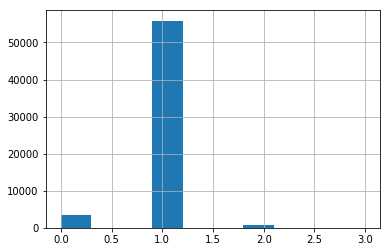

In [17]:
df['DOCUMENT_COUNT'] = df[docs].sum(axis=1) # 각 줄단위로 합함
print(df['DOCUMENT_COUNT'].shape)
# 결과를 보니 대부분이 1이라고 답함
print(df['DOCUMENT_COUNT'].value_counts())
df['DOCUMENT_COUNT'].hist()

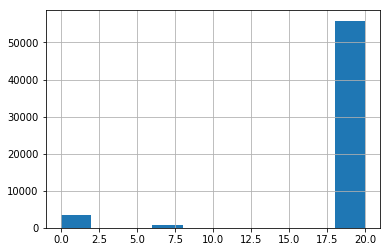

In [18]:
# kurtosis는 분산이 얼마나 쏠려있는지 알려주는 기능
# 대부분이 20쪽으로 쏠려있다.
df[docs].kurtosis(axis=1).hist()
df['NEW_DOC_KURT']=df[docs].kurtosis(axis=1)

In [19]:
# 일괄 적용을 위해 get_age_label 함수를 정의한다.
def get_age_label(days_birth):
    """ Return the age group label (int)"""
    age_year = -days_birth/365
    if age_year < 27: return 1
    elif age_year < 40: return 2
    elif age_year < 50: return 3
    elif age_year < 65: return 4
    elif age_year < 99: return 5
    else: return 0

In [20]:
# DAYS_BIRTH를 보면 기준일 - 태어난 날로 계산되어 있다. (-9461, -16765, ...)
print(df['DAYS_BIRTH'].head())
df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x:get_age_label(x))
# 함수 적용 결과 카테고리 값으로 변한 것을 확인 가능.
print(df['AGE_RANGE'].head())

0    -9461
1   -16765
2   -19046
3   -19005
4   -19932
Name: DAYS_BIRTH, dtype: int64
0    1
1    3
2    4
3    4
4    4
Name: AGE_RANGE, dtype: int64


In [21]:
# EXE_SOURCE 값을 확인해본다.
# 피쳐중에서 영향력이 제일 높다.
print(df['EXT_SOURCE_1'].value_counts().head())

# 유사한 피쳐들을 합쳐서 계산한다.
# 중간에 NaN값이 있으면 결과도 NaN가 나온다.
df['EXT_SOURCE_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
df['EXT_SOURCE_PROD'].head()

0.489916    5
0.377668    4
0.415281    4
0.448823    3
0.228382    3
Name: EXT_SOURCE_1, dtype: int64


0    0.003043
1         NaN
2         NaN
3         NaN
4         NaN
Name: EXT_SOURCE_PROD, dtype: float64

In [22]:
# 각각의 피쳐에 가중치를 줄 수 있다.
df['EXT_SOURCES_WEIGHTED'] = df.EXT_SOURCE_1*2 + df.EXT_SOURCE_2*1 + df.EXT_SOURCE_3*3
df['EXT_SOURCES_WEIGHTED'].head()

0    0.84715
1        NaN
2        NaN
3        NaN
4        NaN
Name: EXT_SOURCES_WEIGHTED, dtype: float64

In [23]:
np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encounterd')

In [24]:
for function_name in 'min max mean nanmedian var'.split():
    break

In [25]:
feature_name = 'EXE_SOURCES_{}'.format(function_name.upper())
print(' feature_name : ', feature_name)

# eval은 위에서 정의한 min max mean nanmedian var를 일괄적으로 계산해준다.
# 반복 작업을 줄일 수 있다.
# eval은 문자열을 함수로 작동할 수 있도록 하는 기능을 한다.
df[feature_name] = eval('np.{}'.format(function_name))(
    df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)
df[feature_name].head()


 feature_name :  EXE_SOURCES_MIN


0    0.083037
1    0.311267
2    0.555912
3    0.650442
4    0.322738
Name: EXE_SOURCES_MIN, dtype: float64

In [26]:
# eval 함수는 이런식으로 계산된다.
eval('np.min')(df[['EXT_SOURCE_1']],axis=1).head()

0    0.083037
1    0.311267
2         NaN
3         NaN
4         NaN
dtype: float64

In [27]:
# 정상적으로 작동할 경우
for function_name in 'min max mean nanmedian var'.split():
    feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
    print(' feature_name : ', feature_name)
    df[feature_name] = eval('np.{}'.format(function_name))(
        df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)
    df[feature_name].head()

 feature_name :  EXT_SOURCES_MIN
 feature_name :  EXT_SOURCES_MAX
 feature_name :  EXT_SOURCES_MEAN
 feature_name :  EXT_SOURCES_NANMEDIAN
 feature_name :  EXT_SOURCES_VAR


/Users/jang/.pyenv/versions/3.6.5/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [28]:
# 작업 결과 EXT_SOURCES_MIN, EXT_SOURCES_MAX, EXT_SOURCES_NANMEDIAN, EXT_SOURCES_VAR 칼럼이 생성되었다.
# EXT가 포함된 칼럼 출력
df.filter(like='EXT').head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_PROD,EXT_SOURCES_WEIGHTED,EXT_SOURCES_MIN,EXT_SOURCES_MAX,EXT_SOURCES_MEAN,EXT_SOURCES_NANMEDIAN,EXT_SOURCES_VAR
0,0.083037,0.262949,0.139376,0.003043,0.84715,0.083037,0.262949,0.161787,0.139376,0.005646
1,0.311267,0.622246,NaN,NaN,NaN,0.311267,0.622246,0.466757,0.466757,0.024177
2,NaN,0.555912,0.729567,NaN,NaN,0.555912,0.729567,0.642739,0.642739,0.007539
3,NaN,0.650442,NaN,NaN,NaN,0.650442,0.650442,0.650442,0.650442,0.000000
4,NaN,0.322738,NaN,NaN,NaN,0.322738,0.322738,0.322738,0.322738,0.000000


In [29]:
# 새로운 비율값을 생성한다.
# 보험금 / 연금의 비율 
df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
df[['AMT_CREDIT', 'AMT_ANNUITY', 'CREDIT_TO_ANNUITY_RATIO']].head()

,AMT_CREDIT,AMT_ANNUITY,CREDIT_TO_ANNUITY_RATIO
0,406597.5,24700.5,16.461104
1,1293502.5,35698.5,36.234085
2,135000.0,6750.0,20.000000
3,312682.5,29686.5,10.532818
4,513000.0,21865.5,23.461618


In [30]:
# AMT_GOODS_PRICE : 가전제품의 총 구매 비용, 수익이라고 판단할 수 있다.
# CREDIT_TO_GOODS_RATIO : 신용(부체, 대출) 대비 수익의 비율
# 1이 넘어가면 수익보다 과소비 한다고 판단할 수 있다.
df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
df['AMT_CREDIT AMT_GOODS_PRICE CREDIT_TO_ANNUITY_RATIO CREDIT_TO_GOODS_RATIO'.split()].head()

,AMT_CREDIT,AMT_GOODS_PRICE,CREDIT_TO_ANNUITY_RATIO,CREDIT_TO_GOODS_RATIO
0,406597.5,351000.0,16.461104,1.158397
1,1293502.5,1129500.0,36.234085,1.145199
2,135000.0,135000.0,20.000000,1.000000
3,312682.5,297000.0,10.532818,1.052803
4,513000.0,513000.0,23.461618,1.000000


In [31]:
# 수익 관련 변수를 생성한다.
df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
df['ANNUITY_TO_INCOME_RATIO CREDIT_TO_INCOME_RATIO INCOME_TO_EMPLOYED_RATIO INCOME_TO_BIRTH_RATIO'.split()].head()

,ANNUITY_TO_INCOME_RATIO,CREDIT_TO_INCOME_RATIO,INCOME_TO_EMPLOYED_RATIO,INCOME_TO_BIRTH_RATIO
0,0.121978,2.007889,-317.896389,-21.403657
1,0.132217,4.790750,-227.272727,-16.104981
2,0.100000,2.000000,-300.000000,-3.544051
3,0.219900,2.316167,-44.422507,-7.103394
4,0.179963,4.222222,-39.993417,-6.095725


In [32]:
# 시간 관련 변수를 생성한다.
df['EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
df['EMPLOYED_TO_BIRTH_RATIO ID_TO_BIRTH_RATIO CAR_TO_BIRTH_RATIO CAR_TO_EMPLOYED_RATIO PHONE_TO_BIRTH_RATIO'.split()].head()

,EMPLOYED_TO_BIRTH_RATIO,ID_TO_BIRTH_RATIO,CAR_TO_BIRTH_RATIO,CAR_TO_EMPLOYED_RATIO,PHONE_TO_BIRTH_RATIO
0,0.067329,0.224078,NaN,NaN,0.119860
1,0.070862,0.017358,NaN,NaN,0.049389
2,0.011814,0.132889,-0.001365,-0.115556,0.042791
3,0.159905,0.128229,NaN,NaN,0.032465
4,0.152418,0.173490,NaN,NaN,0.055489


In [33]:
# 변수 생성에 필요한 함수를 정의한다.
def do_median(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].median().reset_index().rename(
        columns = {counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    print(' -> group_cols : ', group_cols)
    print(' -> counted : ', counted)
    return df

In [34]:
def do_std(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].std().reset_index().rename(
        columns = {counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    print(' -> group_cols : ', group_cols)
    print(' -> counted : ', counted)
    return df

In [35]:
def do_mean(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    print(' -> group_cols : ', group_cols)
    print(' -> counted : ', counted)
    return df

In [36]:
# 그룹화 정보 
group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']
df = do_median(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN')
df.filter(like='GROUP_EXT_SOURCES_MEDIAN').head()

 -> group_cols :  ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']
 -> counted :  EXT_SOURCES_MEAN


,GROUP_EXT_SOURCES_MEDIAN
0,0.378817
1,0.572513
2,0.602979
3,0.577263
4,0.322738


In [37]:
df = do_std(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_STD')
df.filter(like='GROUP_EXT_SOURCES_STD').head()

 -> group_cols :  ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']
 -> counted :  EXT_SOURCES_MEAN


,GROUP_EXT_SOURCES_STD
0,0.133317
1,0.125299
2,0.126065
3,0.146419
4,NaN


In [38]:
df = do_mean(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_MEAN')
df = do_std(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_STD')
df = do_mean(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_MEAN')
df = do_std(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_STD')
df = do_mean(df, group, 'AMT_CREDIT', 'GROUP_CREDIT_MEAN')
df = do_mean(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')
df = do_std(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_STD')
df.filter(like='GROUP_').head()

 -> group_cols :  ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']
 -> counted :  AMT_INCOME_TOTAL
 -> group_cols :  ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']
 -> counted :  AMT_INCOME_TOTAL
 -> group_cols :  ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']
 -> counted :  CREDIT_TO_ANNUITY_RATIO
 -> group_cols :  ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']
 -> counted :  CREDIT_TO_ANNUITY_RATIO
 -> group_cols :  ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']
 -> counted :  AMT_CREDIT
 -> group_cols :  ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']
 -> counted :  AMT_ANNUITY
 -> group_cols :  ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']
 -> counted :  AMT_ANNUITY


,GROUP_EXT_SOURCES_MEDIAN,GROUP_EXT_SOURCES_STD,GROUP_INCOME_MEAN_x,GROUP_INCOME_MEAN_y,GROUP_INCOME_STD,GROUP_CREDIT_TO_ANNUITY_MEAN_x,GROUP_CREDIT_TO_ANNUITY_MEAN_y,GROUP_CREDIT_TO_ANNUITY_STD,GROUP_CREDIT_MEAN_x,GROUP_CREDIT_MEAN_y,GROUP_ANNUITY_MEAN_x,GROUP_ANNUITY_MEAN_y,GROUP_ANNUITY_STD
0,0.378817,0.133317,163184.210526,163184.210526,56863.585338,15.136192,15.136192,5.392621,398217.105263,398217.105263,26373.078947,26373.078947,12692.308396
1,0.572513,0.125299,177523.809524,177523.809524,71230.508452,21.846602,21.846602,7.363209,714662.857143,714662.857143,32226.785714,32226.785714,16084.101586
2,0.602979,0.126065,159818.181818,159818.181818,83879.453885,19.361810,19.361810,8.954275,538424.863636,538424.863636,28293.545455,28293.545455,13928.624641
3,0.577263,0.146419,158850.918367,158850.918367,64477.078638,21.117754,21.117754,7.793936,591121.010204,591121.010204,27773.742857,27773.742857,12957.778201
4,0.322738,NaN,121500.000000,121500.000000,NaN,23.461618,23.461618,NaN,513000.000000,513000.000000,21865.500000,21865.500000,NaN


In [39]:
# 라벨 인코더 함수 정의
def label_encoder(df, categorical_columns=None):
    """Encode categorical values as integers (0, 1, 2, 3, ...) with pandas.factorize"""
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    for col in categorical_columns:
        df[col], unique = pd.factorize(df[col])

    return df, categorical_columns

In [40]:
# 라벨 인코더 함수 뜯어보기
categorical_columns = None
if not categorical_columns:
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']

# 모든 칼럼을 돌면서 오프젝트 타입인 것만 조회
print(' ---> len : ',len(categorical_columns))
categorical_columns

 ---> len :  16


['CODE_GENDER',
 'EMERGENCYSTATE_MODE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'NAME_CONTRACT_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'NAME_INCOME_TYPE',
 'NAME_TYPE_SUITE',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'WALLSMATERIAL_MODE',
 'WEEKDAY_APPR_PROCESS_START']

In [41]:
# 조회된 데이터를 확인하면 이런 종류들이다.
df[categorical_columns].head()

,CODE_GENDER,EMERGENCYSTATE_MODE,FLAG_OWN_CAR,FLAG_OWN_REALTY,FONDKAPREMONT_MODE,HOUSETYPE_MODE,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,OCCUPATION_TYPE,ORGANIZATION_TYPE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START
0,M,No,N,Y,reg oper account,block of flats,Cash loans,Secondary / secondary special,Single / not married,House / apartment,Working,Unaccompanied,Laborers,Business Entity Type 3,"Stone, brick",WEDNESDAY
1,F,No,N,N,reg oper account,block of flats,Cash loans,Higher education,Married,House / apartment,State servant,Family,Core staff,School,Block,MONDAY
2,M,NaN,Y,Y,NaN,NaN,Revolving loans,Secondary / secondary special,Single / not married,House / apartment,Working,Unaccompanied,Laborers,Government,NaN,MONDAY
3,F,NaN,N,Y,NaN,NaN,Cash loans,Secondary / secondary special,Civil marriage,House / apartment,Working,Unaccompanied,Laborers,Business Entity Type 3,NaN,WEDNESDAY
4,M,NaN,N,Y,NaN,NaN,Cash loans,Secondary / secondary special,Single / not married,House / apartment,Working,Unaccompanied,Core staff,Religion,NaN,THURSDAY


In [42]:
# factorize 하면 변수의 종류와 값이 나온다.
# -1값은 NAN값이다.
print(' CODE_GENDER : ', pd.factorize(df['CODE_GENDER']))
print(' EMERGENCYSTATE_MODE : ', pd.factorize(df['EMERGENCYSTATE_MODE']))
print(' ORGANIZATION_TYPE : ', pd.factorize(df['ORGANIZATION_TYPE']))

 CODE_GENDER :  (array([0, 1, 0, ..., 1, 1, 1]), Index(['M', 'F'], dtype='object'))
 EMERGENCYSTATE_MODE :  (array([ 0,  0, -1, ..., -1,  0, -1]), Index(['No', 'Yes'], dtype='object'))
 ORGANIZATION_TYPE :  (array([0, 1, 2, ..., 0, 0, 7]), Index(['Business Entity Type 3', 'School', 'Government', 'Religion', 'Other',
       'XNA', 'Electricity', 'Medicine', 'Business Entity Type 2',
       'Self-employed', 'Transport: type 2', 'Construction', 'Housing',
       'Kindergarten', 'Trade: type 7', 'Industry: type 11', 'Military',
       'Services', 'Security Ministries', 'Transport: type 4',
       'Industry: type 1', 'Emergency', 'Security', 'Trade: type 2',
       'University', 'Transport: type 3', 'Police', 'Business Entity Type 1',
       'Postal', 'Industry: type 4', 'Agriculture', 'Restaurant', 'Culture',
       'Hotel', 'Industry: type 7', 'Trade: type 3', 'Industry: type 3',
       'Bank', 'Industry: type 9', 'Insurance', 'Trade: type 6',
       'Industry: type 2', 'Transport: type 1

In [43]:
df.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,EMERGENCYSTATE_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,...,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE,DOCUMENT_COUNT,NEW_DOC_KURT,AGE_RANGE,EXT_SOURCE_PROD,EXT_SOURCES_WEIGHTED,EXE_SOURCES_MIN,EXT_SOURCES_MIN,EXT_SOURCES_MAX,EXT_SOURCES_MEAN,EXT_SOURCES_NANMEDIAN,EXT_SOURCES_VAR,CREDIT_TO_ANNUITY_RATIO,CREDIT_TO_GOODS_RATIO,ANNUITY_TO_INCOME_RATIO,CREDIT_TO_INCOME_RATIO,INCOME_TO_EMPLOYED_RATIO,INCOME_TO_BIRTH_RATIO,EMPLOYED_TO_BIRTH_RATIO,ID_TO_BIRTH_RATIO,CAR_TO_BIRTH_RATIO,CAR_TO_EMPLOYED_RATIO,PHONE_TO_BIRTH_RATIO,GROUP_EXT_SOURCES_MEDIAN,GROUP_EXT_SOURCES_STD,GROUP_INCOME_MEAN_x,GROUP_INCOME_MEAN_y,GROUP_INCOME_STD,GROUP_CREDIT_TO_ANNUITY_MEAN_x,GROUP_CREDIT_TO_ANNUITY_MEAN_y,GROUP_CREDIT_TO_ANNUITY_STD,GROUP_CREDIT_MEAN_x,GROUP_CREDIT_MEAN_y,GROUP_ANNUITY_MEAN_x,GROUP_ANNUITY_MEAN_y,GROUP_ANNUITY_STD
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0247,0.0250,0.0252,0.0369,0.0369,0.0383,0,1.0,M,0.0143,0.0144,0.0144,-9461,-637.0,-2120,-1134.0,-3648.0,2.0,2.0,0.00,0.00,0.0000,No,0.0690,0.0690,0.0690,0.083037,0.262949,0.139376,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,100002,1.0,0.0149,"Stone, brick",WEDNESDAY,0.9722,0.9722,0.9722,0.6192,0.6243,0.6341,1,20.0,1,0.003043,0.84715,0.083037,0.083037,0.262949,0.161787,0.139376,0.005646,16.461104,1.158397,0.121978,2.007889,-317.896389,-21.403657,0.067329,0.224078,NaN,NaN,0.119860,0.378817,0.133317,163184.210526,163184.210526,56863.585338,15.136192,15.136192,5.392621,398217.105263,398217.105263,26373.078947,26373.078947,12692.308396
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0959,0.0968,0.0924,0.0529,0.0529,0.0538,0,2.0,F,0.0605,0.0608,0.0497,-16765,-1188.0,-291,-828.0,-1186.0,0.0,0.0,0.08,0.08,0.0806,No,0.0345,0.0345,0.0345,0.311267,0.622246,NaN,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,100003,0.0,0.0714,Block,MONDAY,0.9851,0.9851,0.9851,0.7960,0.7987,0.8040,1,20.0,3,NaN,NaN,0.311267,0.311267,0.622246,0.466757,0.466757,0.024177,36.234085,1.145199,0.132217,4.790750,-227.272727,-16.104981,0.070862,0.017358,NaN,NaN,0.049389,0.572513,0.125299,177523.809524,177523.809524,71230.508452,21.846602,21.846602,7.363209,714662.857143,714662.857143,32226.785714,32226.785714,16084.101586
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,M,NaN,NaN,NaN,-19046,-225.0,-2531,-815.0,-4260.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.555912,0.729567,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,100004,0.0,NaN,NaN,MONDAY,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,4,NaN,NaN,0.555912,0.555912,0.729567,0.642739,0.642739,0.007539,20.000000,1.000000,0.100000,2.000000,-300.000000,-3.544051,0.011814,0.132889,-0.001365,-0.115556,0.042791,0.602979,0.126065,159818.181818,159818.181818,83879.453885,19.361810,19.361810,8.954275,538424.863636,538424.863636,28293.545455,28293.545455,13928.624641
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,F,NaN,NaN,NaN,-19005,-3039.0,-243

In [44]:
# 드랍 칼럼 함수를 정의한다.
def drop_application_columns(df):
    """ Drop features based on permutation feature importance"""
    drop_list = [
        'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START',
        'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'FLAG_PHONE',
        'FLAG_OWN_REALTY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
        'REG_CITY_NOT_WORK_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR', 
        'COMMONAREA_MODE', 'NONLIVINGAREA_MODE', 'ELEVATORS_MODE', 'NONLIVINGAREA_AVG',
        'FLOORSMIN_MEDI', 'LANDAREA_MODE', 'NONLIVINGAREA_MEDI', 'LIVINGAPARTMENTS_MODE',
        'FLOORSMIN_AVG', 'LANDAREA_AVG', 'FLOORSMIN_MODE', 'LANDAREA_MEDI',
        'COMMONAREA_MEDI', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'BASEMENTAREA_AVG',
        'BASEMENTAREA_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 
        'LIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG', 'YEARS_BUILD_MEDI', 'ENTRANCES_MODE',
        'NONLIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'LIVINGAPARTMENTS_MEDI',
        'YEARS_BUILD_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_MEDI', 'LIVINGAREA_MEDI',
        'YEARS_BEGINEXPLUATATION_MODE', 'NONLIVINGAPARTMENTS_AVG', 'HOUSETYPE_MODE',
        'FONDKAPREMONT_MODE', 'EMERGENCYSTATE_MODE'
    ]
    # Drop most flag document columns
    for doc_num in [2,4,5,6,7,9,10,11,12,13,14,15,16,17,19,20,21]:
        drop_list.append('FLAG_DOCUMENT_{}'.format(doc_num))
    df.drop(drop_list, axis=1, inplace=True)
    
    return df

In [45]:
# 라벨 인코더, 드랍 칼럼
# 위에서 정의한 라벨인코더 함수를 사용하여 df를 만든다.
print("before df : ", df.shape)
df, le_encoded_cols = label_encoder(df, None)
df = drop_application_columns(df)
print("after df : ", df.shape)
df.head()

before df :  (59999, 157)
after df :  (59999, 88)


,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ENTRANCES_AVG,ENTRANCES_MEDI,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_DOCUMENT_18,FLAG_DOCUMENT_3,FLAG_DOCUMENT_8,FLAG_OWN_CAR,FLAG_WORK_PHONE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAREA_AVG,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,OCCUPATION_TYPE,ORGANIZATION_TYPE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,SK_ID_CURR,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_MEDI,DOCUMENT_COUNT,NEW_DOC_KURT,AGE_RANGE,EXT_SOURCE_PROD,EXT_SOURCES_WEIGHTED,EXE_SOURCES_MIN,EXT_SOURCES_MIN,EXT_SOURCES_MAX,EXT_SOURCES_MEAN,EXT_SOURCES_NANMEDIAN,EXT_SOURCES_VAR,CREDIT_TO_ANNUITY_RATIO,CREDIT_TO_GOODS_RATIO,ANNUITY_TO_INCOME_RATIO,CREDIT_TO_INCOME_RATIO,INCOME_TO_EMPLOYED_RATIO,INCOME_TO_BIRTH_RATIO,EMPLOYED_TO_BIRTH_RATIO,ID_TO_BIRTH_RATIO,CAR_TO_BIRTH_RATIO,CAR_TO_EMPLOYED_RATIO,PHONE_TO_BIRTH_RATIO,GROUP_EXT_SOURCES_MEDIAN,GROUP_EXT_SOURCES_STD,GROUP_INCOME_MEAN_x,GROUP_INCOME_MEAN_y,GROUP_INCOME_STD,GROUP_CREDIT_TO_ANNUITY_MEAN_x,GROUP_CREDIT_TO_ANNUITY_MEAN_y,GROUP_CREDIT_TO_ANNUITY_STD,GROUP_CREDIT_MEAN_x,GROUP_CREDIT_MEAN_y,GROUP_ANNUITY_MEAN_x,GROUP_ANNUITY_MEAN_y,GROUP_ANNUITY_STD
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0247,0.0250,0.0252,0,-9461,-637.0,-2120,-1134.0,-3648.0,2.0,2.0,0.0690,0.0690,0.083037,0.262949,0.139376,0,1,0,0,0,0.0833,0.0833,0.0833,0,0,0.0190,0,0,0,0,0,0,0,0,NaN,0.018801,2,2,0,100002,1.0,0.0149,0,0,0.9722,1,20.0,1,0.003043,0.84715,0.083037,0.083037,0.262949,0.161787,0.139376,0.005646,16.461104,1.158397,0.121978,2.007889,-317.896389,-21.403657,0.067329,0.224078,NaN,NaN,0.119860,0.378817,0.133317,163184.210526,163184.210526,56863.585338,15.136192,15.136192,5.392621,398217.105263,398217.105263,26373.078947,26373.078947,12692.308396
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0959,0.0968,0.0924,1,-16765,-1188.0,-291,-828.0,-1186.0,0.0,0.0,0.0345,0.0345,0.311267,0.622246,NaN,0,1,0,0,0,0.2917,0.2917,0.2917,0,0,0.0549,0,1,1,0,1,1,1,1,NaN,0.003541,1,1,0,100003,0.0,0.0714,1,1,0.9851,1,20.0,3,NaN,NaN,0.311267,0.311267,0.622246,0.466757,0.466757,0.024177,36.234085,1.145199,0.132217,4.790750,-227.272727,-16.104981,0.070862,0.017358,NaN,NaN,0.049389,0.572513,0.125299,177523.809524,177523.809524,71230.508452,21.846602,21.846602,7.363209,714662.857143,714662.857143,32226.785714,32226.785714,16084.101586
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,NaN,NaN,NaN,0,-19046,-225.0,-2531,-815.0,-4260.0,0.0,0.0,NaN,NaN,NaN,0.555912,0.729567,0,0,0,1,1,NaN,NaN,NaN,0,0,NaN,1,0,0,0,0,0,0,2,26.0,0.010032,2,2,0,100004,0.0,NaN,-1,1,NaN,0,0.0,4,NaN,NaN,0.555912,0.555912,0.729567,0.642739,0.642739,0.007539,20.000000,1.000000,0.100000,2.000000,-300.000000,-3.544051,0.011814,0.132889,-0.001365,-0.115556,0.042791,0.602979,0.126065,159818.181818,159818.181818,83879.453885,19.361810,19.361810,8.954275,538424.863636,538424.863636,28293.545455,28293.545455,13928.624641
3,29686.5,312682.5,297000.0,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,1,-19005,-3039.0,-2437,-617.0,-9833.0,0.0,0.0,NaN,NaN,NaN,0.650442,NaN,0,1,0,0,0,NaN,NaN,NaN,0,0,NaN,0,0,2,0,0,0,0,0,NaN,0.008019,2,2,0,100006,0.0,NaN,-1,0,NaN,1,20.0,4,NaN,NaN,0.650442,0.650442,0.650442,0.650442,0.650442,0.000000,10.532818,1.052803,0.219900,2.316167,-44.422507,-7.103394,0.159905,0.128229,NaN,NaN,0.032465,0.577263,0.146419,158850.918367,158850.918367,64477.078638,21.117754,21.117754,7.793936,591121.010204,591121.010204,27773.742857,27773.742857,12957.778201
4,21865.5,513000.0,513000.0,121500.0,0.0,0.0,0.0,NaN,NaN,NaN,0,-19932,

<br>
<br>
<br>
<br>

# get_bureau() 함수

In [46]:
# 이제 bureau_df를 볼 차례
# get_bureau 함수 정의
def get_bureau(path, num_rows= None):
    """ Process bureau.csv and bureau_balance.csv and return a pandas dataframe. """
    bureau = pd.read_csv(os.path.join(path, 'bureau.csv'), nrows= num_rows)
    # Credit duration and credit/account end date difference
    bureau['CREDIT_DURATION'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
    bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    # Credit to debt ratio and difference
    bureau['DEBT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
    bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']

    # One-hot encoder
    bureau, categorical_cols = one_hot_encoder(bureau, nan_as_category= False)
    # Join bureau balance features
    bureau = bureau.merge(get_bureau_balance(path, num_rows), how='left', on='SK_ID_BUREAU')
    # Flag months with late payments (days past due)
    bureau['STATUS_12345'] = 0
    for i in range(1,6):
        bureau['STATUS_12345'] += bureau['STATUS_{}'.format(i)]

    # Aggregate by number of months in balance and merge with bureau (loan length agg)
    features = ['AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_CREDIT_SUM',
        'AMT_CREDIT_SUM_DEBT', 'DEBT_PERCENTAGE', 'DEBT_CREDIT_DIFF', 'STATUS_0', 'STATUS_12345']
    agg_length = bureau.groupby('MONTHS_BALANCE_SIZE')[features].mean().reset_index()
    agg_length.rename({feat: 'LL_' + feat for feat in features}, axis=1, inplace=True)
    bureau = bureau.merge(agg_length, how='left', on='MONTHS_BALANCE_SIZE')
    del agg_length; gc.collect()

    # General loans aggregations
    agg_bureau = group(bureau, 'BUREAU_', BUREAU_AGG)
    # Active and closed loans aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    agg_bureau = group_and_merge(active,agg_bureau,'BUREAU_ACTIVE_',BUREAU_ACTIVE_AGG)
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    agg_bureau = group_and_merge(closed,agg_bureau,'BUREAU_CLOSED_',BUREAU_CLOSED_AGG)
    del active, closed; gc.collect()
    # Aggregations for the main loan types
    for credit_type in ['Consumer credit', 'Credit card', 'Mortgage', 'Car loan', 'Microloan']:
        type_df = bureau[bureau['CREDIT_TYPE_' + credit_type] == 1]
        prefix = 'BUREAU_' + credit_type.split(' ')[0].upper() + '_'
        agg_bureau = group_and_merge(type_df, agg_bureau, prefix, BUREAU_LOAN_TYPE_AGG)
        del type_df; gc.collect()
    # Time based aggregations: last x months
    for time_frame in [6, 12]:
        prefix = "BUREAU_LAST{}M_".format(time_frame)
        time_frame_df = bureau[bureau['DAYS_CREDIT'] >= -30*time_frame]
        agg_bureau = group_and_merge(time_frame_df, agg_bureau, prefix, BUREAU_TIME_AGG)
        del time_frame_df; gc.collect()

    # Last loan max overdue
    sort_bureau = bureau.sort_values(by=['DAYS_CREDIT'])
    gr = sort_bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].last().reset_index()
    gr.rename({'AMT_CREDIT_MAX_OVERDUE': 'BUREAU_LAST_LOAN_MAX_OVERDUE'}, inplace=True)
    agg_bureau = agg_bureau.merge(gr, on='SK_ID_CURR', how='left')
    # Ratios: total debt/total credit and active loans debt/ active loans credit
    agg_bureau['BUREAU_DEBT_OVER_CREDIT'] = \
        agg_bureau['BUREAU_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_AMT_CREDIT_SUM_SUM']
    agg_bureau['BUREAU_ACTIVE_DEBT_OVER_CREDIT'] = \
        agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM']
    return agg_bureau



<br><br>


# 위 함수를 하나씩 뜯어보자

In [47]:
# 새로 불러옴.
bureau = pd.read_csv(os.path.join(path, 'bureau.csv'), nrows= num_rows)
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [48]:
# Credit duration and credit/account end date difference
bureau['CREDIT_DURATION'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']

# Credit to debt ratio and difference
bureau['DEBT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_DURATION,ENDDATE_DIF,DEBT_PERCENTAGE,DEBT_CREDIT_DIFF,CREDIT_TO_ANNUITY_RATIO
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,344.0,0.0,inf,91323.0,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,1283.0,NaN,1.313163,53658.0,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,731.0,NaN,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,1826.0,NaN,NaN,NaN,NaN


<a class='anchor' id='one_hot_encoder'></a>
### one_hot_encoder 함수

In [49]:
def one_hot_encoder(df, categorical_columns=None, nan_as_category=True):
    """Create a new column for each categorical value in categorical columns. """
    original_columns = list(df.columns)
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    # dummy_na : null을 하나의 카테고리로 치냐 안치냐 옵션
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    categorical_columns = [c for c in df.columns if c not in original_columns]
    return df, categorical_columns

In [50]:
# One_hot encoder
bureau, categorical_cols = one_hot_encoder(bureau, nan_as_category=False)
categorical_cols

['CREDIT_ACTIVE_Active',
 'CREDIT_ACTIVE_Bad debt',
 'CREDIT_ACTIVE_Closed',
 'CREDIT_ACTIVE_Sold',
 'CREDIT_CURRENCY_currency 1',
 'CREDIT_CURRENCY_currency 2',
 'CREDIT_CURRENCY_currency 3',
 'CREDIT_CURRENCY_currency 4',
 'CREDIT_TYPE_Another type of loan',
 'CREDIT_TYPE_Car loan',
 'CREDIT_TYPE_Consumer credit',
 'CREDIT_TYPE_Credit card',
 'CREDIT_TYPE_Loan for business development',
 'CREDIT_TYPE_Loan for working capital replenishment',
 'CREDIT_TYPE_Microloan',
 'CREDIT_TYPE_Mortgage',
 'CREDIT_TYPE_Real estate loan',
 'CREDIT_TYPE_Unknown type of loan']

In [51]:
# SK_ID_CURR 칼럼 정보>
bureau.filter(like='SK_ID_CURR').head()

,SK_ID_CURR
0,215354
1,215354
2,215354
3,215354
4,215354


In [52]:
# group 함수 정의
# get_bureau_balance -> group_and_merge에서 사용
def group(df_to_agg, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
    agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper())
                               for e in agg_df.columns.tolist()])
    return agg_df.reset_index()

In [53]:
# group_and_merge 함수 정의
# get_bureau_balance에서 사용함
def group_and_merge(df_to_agg, df_to_merge, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = group(df_to_agg, prefix, aggregations, aggregate_by= aggregate_by)
    return df_to_merge.merge(agg_df, how='left', on= aggregate_by)

In [54]:
# get_bureau_balance 함수 정의
def get_bureau_balance(path, num_rows=None):
    # bureau_balance.csv 파일을 새로 불러온다.
    # 대출금의 생태를 말해주는 데이터셋
    bb = pd.read_csv(os.path.join(path, 'bureau_balance.csv'), nrows=num_rows)
    bb, categorical_cols = one_hot_encoder(bb, nan_as_category=False)
    # Calcaulate rate for each categorory with decay
    bb_processed = bb.groupby('SK_ID_BUREAU')[categorical_cols].mean().reset_index()
    # Min, Max, Count and Mean duration of payments (months)
    agg = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size']}
    bb_processed = group_and_merge(bb, bb_processed, '', agg, 'SK_ID_BUREAU')
    del bb; gc.collect()
    return bb_processed

<br>
<br>
<br>
<br>
<br>

## get_bureau_balance 함수를 뜯어보자.

In [55]:
# 위 get_bureau_balance 함수를 뜯어보자
bb = pd.read_csv(os.path.join(path, 'bureau_balance.csv'), nrows=num_rows)
bb.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [56]:
bb['STATUS'].value_counts()

C    14559
X     7708
0     7525
1      171
2       15
5       14
3        6
4        2
Name: STATUS, dtype: int64

In [57]:
# STATUS 값 만큼 칼럼 생성
bb, categorical_cols = one_hot_encoder(bb, nan_as_category=False)
bb.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X
0,5715448,0,0,0,0,0,0,0,1,0
1,5715448,-1,0,0,0,0,0,0,1,0
2,5715448,-2,0,0,0,0,0,0,1,0
3,5715448,-3,0,0,0,0,0,0,1,0
4,5715448,-4,0,0,0,0,0,0,1,0


In [58]:
categorical_cols

['STATUS_0',
 'STATUS_1',
 'STATUS_2',
 'STATUS_3',
 'STATUS_4',
 'STATUS_5',
 'STATUS_C',
 'STATUS_X']

In [59]:
# categorical_cols 생성된 칼럼별로 계산
bb_processed = bb.groupby('SK_ID_BUREAU')[categorical_cols].mean().reset_index()
bb_processed.head()

,SK_ID_BUREAU,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X
0,5212206,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000
1,5212207,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000
2,5212208,0.000000,0.0,0.0,0.0,0.0,0.0,0.979381,0.020619
3,5212210,0.247059,0.0,0.0,0.0,0.0,0.0,0.447059,0.305882
4,5212211,0.164948,0.0,0.0,0.0,0.0,0.0,0.237113,0.597938


In [60]:
agg = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size']}
agg

{'MONTHS_BALANCE': ['min', 'max', 'mean', 'size']}

<br>
<br>
<br>
<br>

## group 함수를 뜯어보자

In [61]:
# group 함수 정의
# get_bureau_balance -> group_and_merge에서 사용
def group(df_to_agg, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
    agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper())
                               for e in agg_df.columns.tolist()])
    return agg_df.reset_index()

In [62]:
# def group 함수를 뜯어보자
# 인자들을 정의해준다.
df_to_agg = bb
df_to_merge = bb_processed
prefix = ''
aggregations = agg
aggregate_by= 'SK_ID_BUREAU'

In [63]:
agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
agg_df.head()

MONTHS_BALANCE               
                        min max  mean size
SK_ID_BUREAU                              
5212206                 -59   0 -29.5   60
5212207                 -58   0 -29.0   59
5212208                 -96   0 -48.0   97
5212210                 -84   0 -42.0   85
5212211                 -96   0 -48.0   97

In [64]:
# agg_df의 min, max, mean, size를 돌면서 각 칼럼별 값을 추출한다.
print(agg_df.columns.tolist())
agg_df_col = [(prefix, e[0], e[1].upper()) for e in agg_df.columns.tolist()]
agg_df_col

[('MONTHS_BALANCE', 'min'), ('MONTHS_BALANCE', 'max'), ('MONTHS_BALANCE', 'mean'), ('MONTHS_BALANCE', 'size')]


[('', 'MONTHS_BALANCE', 'MIN'),
 ('', 'MONTHS_BALANCE', 'MAX'),
 ('', 'MONTHS_BALANCE', 'MEAN'),
 ('', 'MONTHS_BALANCE', 'SIZE')]

In [65]:
agg_df_columns = ['{}{}_{}'.format(agg[0], agg[1], agg[2]) for agg in agg_df_col]
agg_df_columns

['MONTHS_BALANCE_MIN',
 'MONTHS_BALANCE_MAX',
 'MONTHS_BALANCE_MEAN',
 'MONTHS_BALANCE_SIZE']

In [66]:
# 결과적으로 이렇게 각 연산을 계산하여 반환한다.
agg_df.columns = pd.Index(agg_df_columns)
agg_df.reset_index().head()

,SK_ID_BUREAU,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_MEAN,MONTHS_BALANCE_SIZE
0,5212206,-59,0,-29.5,60
1,5212207,-58,0,-29.0,59
2,5212208,-96,0,-48.0,97
3,5212210,-84,0,-42.0,85
4,5212211,-96,0,-48.0,97


<br>
<br>
<br>
<br>

## group_and_merge 함수를 뜯어보자

In [67]:
# group_and_merge 함수 정의
# get_bureau_balance에서 사용함
def group_and_merge(df_to_agg, df_to_merge, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = group(df_to_agg, prefix, aggregations, aggregate_by= aggregate_by)
    return df_to_merge.merge(agg_df, how='left', on= aggregate_by)

In [68]:
# group함수를 알았으니 group_and_merge 힘수를 뜯어보자.
# 바로 위에서 반환한 agg_df를 사용한다.
# aggregate_by 는 위에서 정의한 SK_ID_BUREAU 이다.
bb_processed = df_to_merge.merge(agg_df, how='left', on=aggregate_by).head()
bb_processed.head()

,SK_ID_BUREAU,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_MEAN,MONTHS_BALANCE_SIZE
0,5212206,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,-59,0,-29.5,60
1,5212207,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,-58,0,-29.0,59
2,5212208,0.000000,0.0,0.0,0.0,0.0,0.0,0.979381,0.020619,-96,0,-48.0,97
3,5212210,0.247059,0.0,0.0,0.0,0.0,0.0,0.447059,0.305882,-84,0,-42.0,85
4,5212211,0.164948,0.0,0.0,0.0,0.0,0.0,0.237113,0.597938,-96,0,-48.0,97


<br>
<br>
<br>
<br>

## 다시 get_bureau()으로 돌아와서 위 작업 재실행하고 이어서 진행

In [69]:
# 다시 함수 과정 돌아와서 위 작업 재실행

bureau = pd.read_csv(os.path.join(path, 'bureau.csv'), nrows= num_rows)
# Credit duration and credit/account end date difference
bureau['CREDIT_DURATION'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
# Credit to debt ratio and difference
bureau['DEBT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']

# One-hot encoder
bureau, categorical_cols = one_hot_encoder(bureau, nan_as_category= False)
# Join bureau balance features
bureau = bureau.merge(get_bureau_balance(path, num_rows), how='left', on='SK_ID_BUREAU')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_DURATION,ENDDATE_DIF,DEBT_PERCENTAGE,DEBT_CREDIT_DIFF,CREDIT_TO_ANNUITY_RATIO,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_MEAN,MONTHS_BALANCE_SIZE
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,-131,NaN,344.0,0.0,inf,91323.0,NaN,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,-20,NaN,1283.0,NaN,1.313163,53658.0,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,-16,NaN,731.0,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,-16,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,-21,NaN,1826.0,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
# Flag months with late payments (days past due)
# STATUS_12345 칼럼을0으로 채운다.
bureau['STATUS_12345'] = 0
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_DURATION,ENDDATE_DIF,DEBT_PERCENTAGE,DEBT_CREDIT_DIFF,CREDIT_TO_ANNUITY_RATIO,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_MEAN,MONTHS_BALANCE_SIZE,STATUS_12345
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,-131,NaN,344.0,0.0,inf,91323.0,NaN,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,-20,NaN,1283.0,NaN,1.313163,53658.0,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,-16,NaN,731.0,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,-16,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,-21,NaN,1826.0,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [71]:
# STATUS 시리즈 칼럼들의 값을 더하는데 다 NAN이다...
for i in range(1,6):
    bureau['STATUS_12345'] += bureau['STATUS_{}'.format(i)]
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_DURATION,ENDDATE_DIF,DEBT_PERCENTAGE,DEBT_CREDIT_DIFF,CREDIT_TO_ANNUITY_RATIO,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_MEAN,MONTHS_BALANCE_SIZE,STATUS_12345
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,-131,NaN,344.0,0.0,inf,91323.0,NaN,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,-20,NaN,1283.0,NaN,1.313163,53658.0,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,-16,NaN,731.0,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,-16,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,-21,NaN,1826.0,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
# Aggregate by number of months in balance and merge with bureau (loan length agg)
features = ['AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_CREDIT_SUM',
    'AMT_CREDIT_SUM_DEBT', 'DEBT_PERCENTAGE', 'DEBT_CREDIT_DIFF', 'STATUS_0', 'STATUS_12345']

In [73]:
# 위에서 정의한 칼럼들만 추출하여 평균을 계산하다.
# MONTHS_BALANCE_SIZE 값 별로 묶는다.
agg_length = bureau.groupby('MONTHS_BALANCE_SIZE')[features].mean().reset_index()
agg_length.head()

,MONTHS_BALANCE_SIZE,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,DEBT_PERCENTAGE,DEBT_CREDIT_DIFF,STATUS_0,STATUS_12345
0,1.0,0.0,0.0,63225.000,61878.0,1.015670,1347.000,1.000000,0.0
1,2.0,NaN,0.0,170712.000,176040.0,0.969734,-5328.000,1.000000,0.0
2,4.0,NaN,0.0,1165329.000,1140736.5,1.191588,24592.500,1.000000,0.0
3,5.0,0.0,0.0,711386.085,0.0,inf,711386.085,0.466667,0.0
4,6.0,NaN,0.0,157095.000,101398.5,1.489501,55696.500,0.916667,0.0


In [74]:
# 구분하기 위해 칼럼명에 LL을 붙여준다.
agg_length.rename({feat: 'LL_' + feat for feat in features}, axis=1, inplace=True)
agg_length.head()

,MONTHS_BALANCE_SIZE,LL_AMT_CREDIT_MAX_OVERDUE,LL_AMT_CREDIT_SUM_OVERDUE,LL_AMT_CREDIT_SUM,LL_AMT_CREDIT_SUM_DEBT,LL_DEBT_PERCENTAGE,LL_DEBT_CREDIT_DIFF,LL_STATUS_0,LL_STATUS_12345
0,1.0,0.0,0.0,63225.000,61878.0,1.015670,1347.000,1.000000,0.0
1,2.0,NaN,0.0,170712.000,176040.0,0.969734,-5328.000,1.000000,0.0
2,4.0,NaN,0.0,1165329.000,1140736.5,1.191588,24592.500,1.000000,0.0
3,5.0,0.0,0.0,711386.085,0.0,inf,711386.085,0.466667,0.0
4,6.0,NaN,0.0,157095.000,101398.5,1.489501,55696.500,0.916667,0.0


In [75]:
# 이제 bureau와 새로 추출한 테이블끼리 붙인다.
# 칼럼이 66개나 된다...
bureau = bureau.merge(agg_length, how='left', on='MONTHS_BALANCE_SIZE')
print(bureau.shape)
bureau.head()

(30000, 58)


,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_DURATION,ENDDATE_DIF,DEBT_PERCENTAGE,DEBT_CREDIT_DIFF,CREDIT_TO_ANNUITY_RATIO,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_MEAN,MONTHS_BALANCE_SIZE,STATUS_12345,LL_AMT_CREDIT_MAX_OVERDUE,LL_AMT_CREDIT_SUM_OVERDUE,LL_AMT_CREDIT_SUM,LL_AMT_CREDIT_SUM_DEBT,LL_DEBT_PERCENTAGE,LL_DEBT_CREDIT_DIFF,LL_STATUS_0,LL_STATUS_12345
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,-131,NaN,344.0,0.0,inf,91323.0,NaN,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,-20,NaN,1283.0,NaN,1.313163,53658.0,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,-16,NaN,731.0,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,-16,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,-21,NaN,1826.0,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
# 안쓰는 변수는 지워준다.
del agg_length; gc.collect()

49

<br>
<br>
<br>
<br>

## get_bureau 함수 General loan aggregations 부분

In [77]:
# 파라미터 정의

# AGGREGATIONS
# 각 칼럼별로 사용할 연산을 정의
BUREAU_AGG = {
    'SK_ID_BUREAU': ['nunique'],    # SK_ID_BUREAU는 nunique을 적용하겠다는 의미
    'DAYS_CREDIT': ['min', 'max', 'mean'],   # DAYS_CREDIT는 min, max, mean을 적용하겠다는 의미
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean', 'sum'],
    'MONTHS_BALANCE_MEAN': ['mean', 'var'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
    # Categorical
    'STATUS_0': ['mean'],
    'STATUS_1': ['mean'],
    'STATUS_12345': ['mean'],
    'STATUS_C': ['mean'],
    'STATUS_X': ['mean'],
    'CREDIT_ACTIVE_Active': ['mean'],
    'CREDIT_ACTIVE_Closed': ['mean'],
    'CREDIT_ACTIVE_Sold': ['mean'],
    'CREDIT_TYPE_Consumer credit': ['mean'],
    'CREDIT_TYPE_Credit card': ['mean'],
    'CREDIT_TYPE_Car loan': ['mean'],
    'CREDIT_TYPE_Mortgage': ['mean'],
    'CREDIT_TYPE_Microloan': ['mean'],
    # Group by loan duration features (months)
    'LL_AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'LL_DEBT_CREDIT_DIFF': ['mean'],
    'LL_STATUS_12345': ['mean'],
}

# BUREAU_ACTIVE_AGG
BUREAU_ACTIVE_AGG = {
    'DAYS_CREDIT': ['max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['min', 'mean'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'CREDIT_TO_ANNUITY_RATIO': ['mean'],
    'MONTHS_BALANCE_MEAN': ['mean', 'var'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
}

# BUREAU_CLOSED_AGG
BUREAU_CLOSED_AGG = {
    'DAYS_CREDIT': ['max', 'var'],
    'DAYS_CREDIT_ENDDATE': ['max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'sum'],
    'DAYS_CREDIT_UPDATE': ['max'],
    'ENDDATE_DIF': ['mean'],
    'STATUS_12345': ['mean'],
}

# BUREAU_LOAN_TYPE_AGG
BUREAU_LOAN_TYPE_AGG = {
    'DAYS_CREDIT': ['mean', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
    'AMT_CREDIT_SUM': ['mean', 'max'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'max'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'DAYS_CREDIT_ENDDATE': ['max'],
}

# BUREAU_TIME_AGG
BUREAU_TIME_AGG = {
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'STATUS_0': ['mean'],
    'STATUS_12345': ['mean'],
}


In [78]:
# 이후 진행할부분
# General loans aggregations
agg_bureau = group(bureau, 'BUREAU_', BUREAU_AGG)
# Active and closed loans aggregations
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
agg_bureau = group_and_merge(active,agg_bureau,'BUREAU_ACTIVE_',BUREAU_ACTIVE_AGG)
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
agg_bureau = group_and_merge(closed,agg_bureau,'BUREAU_CLOSED_',BUREAU_CLOSED_AGG)
del active, closed; gc.collect()
# Aggregations for the main loan types
for credit_type in ['Consumer credit', 'Credit card', 'Mortgage', 'Car loan', 'Microloan']:
    type_df = bureau[bureau['CREDIT_TYPE_' + credit_type] == 1]
    prefix = 'BUREAU_' + credit_type.split(' ')[0].upper() + '_'
    agg_bureau = group_and_merge(type_df, agg_bureau, prefix, BUREAU_LOAN_TYPE_AGG)
    del type_df; gc.collect()
# Time based aggregations: last x months
for time_frame in [6, 12]:
    prefix = "BUREAU_LAST{}M_".format(time_frame)
    time_frame_df = bureau[bureau['DAYS_CREDIT'] >= -30*time_frame]
    agg_bureau = group_and_merge(time_frame_df, agg_bureau, prefix, BUREAU_TIME_AGG)
    del time_frame_df; gc.collect()

<br>
<br>
<br>
<br>

## 위 함수 부분을 뜯어보자

### ActiveE Open, Close 칼럼

In [79]:
# general loans aggregations
# BUREAU_AGG를 사용해서 agg_bureau 테이블을 만듬
agg_bureau = group(bureau, 'BUREAU_', BUREAU_AGG)
print(agg_bureau.shape)
agg_bureau.head()

(6076, 41)


,SK_ID_CURR,BUREAU_SK_ID_BUREAU_NUNIQUE,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_AMT_ANNUITY_MEAN,BUREAU_DEBT_CREDIT_DIFF_MEAN,BUREAU_DEBT_CREDIT_DIFF_SUM,BUREAU_MONTHS_BALANCE_MEAN_MEAN,BUREAU_MONTHS_BALANCE_MEAN_VAR,BUREAU_MONTHS_BALANCE_SIZE_MEAN,BUREAU_MONTHS_BALANCE_SIZE_SUM,BUREAU_STATUS_0_MEAN,BUREAU_STATUS_1_MEAN,BUREAU_STATUS_12345_MEAN,BUREAU_STATUS_C_MEAN,BUREAU_STATUS_X_MEAN,BUREAU_CREDIT_ACTIVE_Active_MEAN,BUREAU_CREDIT_ACTIVE_Closed_MEAN,BUREAU_CREDIT_ACTIVE_Sold_MEAN,BUREAU_CREDIT_TYPE_Consumer credit_MEAN,BUREAU_CREDIT_TYPE_Credit card_MEAN,BUREAU_CREDIT_TYPE_Car loan_MEAN,BUREAU_CREDIT_TYPE_Mortgage_MEAN,BUREAU_CREDIT_TYPE_Microloan_MEAN,BUREAU_LL_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_LL_DEBT_CREDIT_DIFF_MEAN,BUREAU_LL_STATUS_12345_MEAN
0,100053,7,-2893,-1764,-2287.714286,-2534.0,-648.0,NaN,NaN,225000.0,92655.642857,648589.50,0.0,0.000000,0.00,0.0,0.0,0.0,NaN,59942.250,239769.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.142857,0.857143,0.0,0.714286,0.285714,0.0,0.0,0.0,NaN,NaN,NaN
1,100312,2,-2604,-613,-1608.500000,-1854.0,117.0,NaN,NaN,1215000.0,832500.000000,1665000.00,113854.5,113854.500000,113854.50,0.0,0.0,0.0,30150.000,1101145.500,1101145.50,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.0,NaN,NaN,NaN
2,100320,5,-2410,-865,-1589.000000,-1400.0,598.0,540.000,108.000,1739394.0,958568.238000,4792841.19,58815.0,12223.732500,48894.93,0.0,0.0,0.0,NaN,751138.065,3004552.26,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.400000,0.600000,0.0,0.400000,0.200000,0.4,0.0,0.0,NaN,NaN,NaN
3,100430,1,-115,-115,-115.000000,31084.0,31084.0,NaN,NaN,67500.0,67500.000000,67500.00,62523.0,62523.000000,62523.00,0.0,0.0,0.0,NaN,4977.000,4977.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.0,NaN,NaN,NaN
4,100568,7,-1274,-207,-493.857143,-969.0,1183.0,8178.885,8178.885,333000.0,119269.877143,834889.14,293535.0,60371.357143,422599.50,0.0,0.0,0.0,5887.125,58898.520,412289.64,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.428571,0.571429,0.0,0.714286,0.285714,0.0,0.0,0.0,NaN,NaN,NaN


In [80]:
bureau['CREDIT_ACTIVE_Active'].head()

0    0
1    1
2    1
3    1
4    1
Name: CREDIT_ACTIVE_Active, dtype: uint8

In [81]:
# Active and Closed Loans Aggregations
# BUREAU_ACTIVE_AGG, BUREAU_CLOSED_AGG에서 정의한 칼럼만 가져와 사용
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
# 11천개의 데이터, 58개의 칼럼
print(active.shape)
active.head()

(11443, 58)


,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_DURATION,ENDDATE_DIF,DEBT_PERCENTAGE,DEBT_CREDIT_DIFF,CREDIT_TO_ANNUITY_RATIO,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_MEAN,MONTHS_BALANCE_SIZE,STATUS_12345,LL_AMT_CREDIT_MAX_OVERDUE,LL_AMT_CREDIT_SUM_OVERDUE,LL_AMT_CREDIT_SUM,LL_AMT_CREDIT_SUM_DEBT,LL_DEBT_PERCENTAGE,LL_DEBT_CREDIT_DIFF,LL_STATUS_0,LL_STATUS_12345
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.0,171342.00,NaN,0.0,-20,NaN,1283.0,NaN,1.313163,53658.00,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,-16,NaN,731.0,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,-16,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,-21,NaN,1826.0,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,215354,5714467,-273,0,27460.0,NaN,0.0,0,180000.0,71017.38,108982.62,0.0,-31,NaN,27733.0,NaN,2.534591,108982.62,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
# active와 agg_bureau를 그룹하고 합친다. 
# BUREAU_ACTIVE_가 들어간 칼럼만 작업(22개)
agg_bureau = group_and_merge(active, agg_bureau, 'BUREAU_ACTIVE_', BUREAU_ACTIVE_AGG)
print(active.shape)
active.head()

(11443, 58)


,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_DURATION,ENDDATE_DIF,DEBT_PERCENTAGE,DEBT_CREDIT_DIFF,CREDIT_TO_ANNUITY_RATIO,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_MEAN,MONTHS_BALANCE_SIZE,STATUS_12345,LL_AMT_CREDIT_MAX_OVERDUE,LL_AMT_CREDIT_SUM_OVERDUE,LL_AMT_CREDIT_SUM,LL_AMT_CREDIT_SUM_DEBT,LL_DEBT_PERCENTAGE,LL_DEBT_CREDIT_DIFF,LL_STATUS_0,LL_STATUS_12345
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.0,171342.00,NaN,0.0,-20,NaN,1283.0,NaN,1.313163,53658.00,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,-16,NaN,731.0,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,-16,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,-21,NaN,1826.0,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,215354,5714467,-273,0,27460.0,NaN,0.0,0,180000.0,71017.38,108982.62,0.0,-31,NaN,27733.0,NaN,2.534591,108982.62,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
# 위에 group_and_merge의 중간과정 
# prefix='BUREAU_ACTIVE_'는 BUREAU_ACTIVE_가 들어간 칼럼만 조회한다는 의미
agg_df = group(active, 'BUREAU_ACTIVE_', BUREAU_ACTIVE_AGG, aggregate_by= aggregate_by)
print(agg_df.shape)
agg_df.head()

(11443, 22)


,SK_ID_BUREAU,BUREAU_ACTIVE_DAYS_CREDIT_MAX,BUREAU_ACTIVE_DAYS_CREDIT_MEAN,BUREAU_ACTIVE_DAYS_CREDIT_ENDDATE_MIN,BUREAU_ACTIVE_DAYS_CREDIT_ENDDATE_MAX,BUREAU_ACTIVE_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_ACTIVE_AMT_CREDIT_SUM_MAX,BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM,BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_ACTIVE_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_ACTIVE_DAYS_CREDIT_UPDATE_MIN,BUREAU_ACTIVE_DAYS_CREDIT_UPDATE_MEAN,BUREAU_ACTIVE_DEBT_PERCENTAGE_MEAN,BUREAU_ACTIVE_DEBT_CREDIT_DIFF_MEAN,BUREAU_ACTIVE_CREDIT_TO_ANNUITY_RATIO_MEAN,BUREAU_ACTIVE_MONTHS_BALANCE_MEAN_MEAN,BUREAU_ACTIVE_MONTHS_BALANCE_MEAN_VAR,BUREAU_ACTIVE_MONTHS_BALANCE_SIZE_MEAN,BUREAU_ACTIVE_MONTHS_BALANCE_SIZE_SUM
0,5189672,-2399,-2399,-1843.0,-1843.0,NaN,NaN,135000.00,135000.00,NaN,0.0,0.0,0.0,-1844,-1844,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,5189679,-1698,-1698,-1036.0,-1036.0,0.0,0.0,4500.00,4500.00,0.0,0.0,0.0,0.0,-693,-693,inf,4500.00,NaN,NaN,NaN,NaN,0.0
2,5189682,-742,-742,1084.0,1084.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,-682,-682,NaN,0.00,NaN,NaN,NaN,NaN,0.0
3,5189683,-339,-339,-94.0,-94.0,NaN,NaN,247500.00,247500.00,162616.5,162616.5,0.0,0.0,-20,-20,1.521986,84883.50,NaN,NaN,NaN,NaN,0.0
4,5189684,-2381,-2381,-2259.0,-2259.0,0.0,0.0,25631.19,25631.19,0.0,0.0,0.0,0.0,-940,-940,inf,25631.19,NaN,NaN,NaN,NaN,0.0


In [84]:
# bureau['CREDIT_ACTIVE_Closed']가 1인 경우만 작업
# 위의 ACTIVE_Open==1 작업과 유사
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
agg_bureau = group_and_merge(closed, agg_bureau, 'BUREAU_CLOSED_', BUREAU_CLOSED_AGG)
agg_bureau.head()

,SK_ID_CURR,BUREAU_SK_ID_BUREAU_NUNIQUE,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_AMT_ANNUITY_MEAN,BUREAU_DEBT_CREDIT_DIFF_MEAN,BUREAU_DEBT_CREDIT_DIFF_SUM,BUREAU_MONTHS_BALANCE_MEAN_MEAN,BUREAU_MONTHS_BALANCE_MEAN_VAR,BUREAU_MONTHS_BALANCE_SIZE_MEAN,BUREAU_MONTHS_BALANCE_SIZE_SUM,BUREAU_STATUS_0_MEAN,BUREAU_STATUS_1_MEAN,BUREAU_STATUS_12345_MEAN,BUREAU_STATUS_C_MEAN,BUREAU_STATUS_X_MEAN,BUREAU_CREDIT_ACTIVE_Active_MEAN,BUREAU_CREDIT_ACTIVE_Closed_MEAN,BUREAU_CREDIT_ACTIVE_Sold_MEAN,BUREAU_CREDIT_TYPE_Consumer credit_MEAN,BUREAU_CREDIT_TYPE_Credit card_MEAN,BUREAU_CREDIT_TYPE_Car loan_MEAN,BUREAU_CREDIT_TYPE_Mortgage_MEAN,BUREAU_CREDIT_TYPE_Microloan_MEAN,BUREAU_LL_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_LL_DEBT_CREDIT_DIFF_MEAN,BUREAU_LL_STATUS_12345_MEAN,BUREAU_ACTIVE_DAYS_CREDIT_MAX,BUREAU_ACTIVE_DAYS_CREDIT_MEAN,BUREAU_ACTIVE_DAYS_CREDIT_ENDDATE_MIN,BUREAU_ACTIVE_DAYS_CREDIT_ENDDATE_MAX,BUREAU_ACTIVE_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_ACTIVE_AMT_CREDIT_SUM_MAX,BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM,BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_ACTIVE_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_ACTIVE_DAYS_CREDIT_UPDATE_MIN,BUREAU_ACTIVE_DAYS_CREDIT_UPDATE_MEAN,BUREAU_ACTIVE_DEBT_PERCENTAGE_MEAN,BUREAU_ACTIVE_DEBT_CREDIT_DIFF_MEAN,BUREAU_ACTIVE_CREDIT_TO_ANNUITY_RATIO_MEAN,BUREAU_ACTIVE_MONTHS_BALANCE_MEAN_MEAN,BUREAU_ACTIVE_MONTHS_BALANCE_MEAN_VAR,BUREAU_ACTIVE_MONTHS_BALANCE_SIZE_MEAN,BUREAU_ACTIVE_MONTHS_BALANCE_SIZE_SUM,BUREAU_CLOSED_DAYS_CREDIT_MAX,BUREAU_CLOSED_DAYS_CREDIT_VAR,BUREAU_CLOSED_DAYS_CREDIT_ENDDATE_MAX,BUREAU_CLOSED_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_CLOSED_AMT_CREDIT_SUM_MAX,BUREAU_CLOSED_AMT_CREDIT_SUM_MEAN,BUREAU_CLOSED_AMT_CREDIT_SUM_SUM,BUREAU_CLOSED_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_CLOSED_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_CLOSED_DAYS_CREDIT_UPDATE_MAX,BUREAU_CLOSED_ENDDATE_DIF_MEAN,BUREAU_CLOSED_STATUS_12345_MEAN
0,100053,7,-2893,-1764,-2287.714286,-2534.0,-648.0,NaN,NaN,225000.0,92655.642857,648589.50,0.0,0.000000,0.00,0.0,0.0,0.0,NaN,59942.250,239769.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.142857,0.857143,0.0,0.714286,0.285714,0.0,0.0,0.0,NaN,NaN,NaN,-2338.0,-2338.0,-1958.0,-1958.0,NaN,NaN,48820.5,48820.5,NaN,0.00,0.0,0.0,-1945.0,-1945.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-1764.0,265312.266667,-648.0,NaN,NaN,0.0,225000.00,99961.500,599769.00,0.0,0.0,-630.0,-25.200000,NaN
1,100312,2,-2604,-613,-1608.500000,-1854.0,117.0,NaN,NaN,1215000.0,832500.000000,1665000.00,113854.5,113854.500000,113854.50,0.0,0.0,0.0,30150.000,1101145.500,1101145.50,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,-613.0,-1608.5,-1854.0,117.0,NaN,NaN,1215000.0,1665000.0,113854.500,113854.50,0.0,0.0,-1857.0,-929.000000,10.671515,1101145.500,14.925373,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100320,5,-2410,-865,-1589.000000,-1400.0,598.0,540.000,108.000,1739394.0,958568.238000,4792841.19,58815.0,12223.732500,48894.93,0.0,0.0,0.0,NaN,751138.065,3004552.26,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.400000,0.600000,0.0,0.400000,0.200000,0.4,0.0,0.0,NaN,NaN,NaN,-1202.0,-1468.0,-1082.0,-75.0,0.0,0.0,1350000.0,1354500.0,24447.465,48894.93,0.0,0.0,-686.0,-669.000000,11.249851,652802.535,NaN,NaN,NaN,NaN,0.0,-865.0,599860.333333,598.0,540.000,180.000,0.0,1739394.00,1146113.730,3438341.19,0.0,0.0,-79.0,660.333333,NaN
3,100430,1,-115,-115,-115.000000,3108

In [85]:
# 쓸모없는 변수를 삭제
del active, closed; gc.collect()

126

### Credit의 연관 칼럼들

'Consumer credit', 'Credit card', 'Mortgage', 'Car loan', 'Microloan' 칼럼들을 돌면서 group_and_merge 작업을 수행한다.

In [86]:
for credit_type in ['Consumer credit', 'Credit card', 'Mortgage', 'Car loan', 'Microloan']:
    type_df = bureau[ bureau['CREDIT_TYPE_'+credit_type] == 1 ]
    prefix = 'BUREAU_' + credit_type.split(' ')[0].upper() + '_'
    agg_bureau = group_and_merge(type_df, agg_bureau, prefix, BUREAU_LOAN_TYPE_AGG)
    del type_df; gc.collect()

In [87]:
for credit_type in ['Consumer credit', 'Credit card', 'Mortgage', 'Car loan', 'Microloan']:
    break

In [88]:
# CREDIT_TYPE_Consumer credit가 1인 것만 사용
type_df = bureau[ bureau['CREDIT_TYPE_'+credit_type] == 1 ]
type_df.head()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_DURATION,ENDDATE_DIF,DEBT_PERCENTAGE,DEBT_CREDIT_DIFF,CREDIT_TO_ANNUITY_RATIO,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_MEAN,MONTHS_BALANCE_SIZE,STATUS_12345,LL_AMT_CREDIT_MAX_OVERDUE,LL_AMT_CREDIT_SUM_OVERDUE,LL_AMT_CREDIT_SUM,LL_AMT_CREDIT_SUM_DEBT,LL_DEBT_PERCENTAGE,LL_DEBT_CREDIT_DIFF,LL_STATUS_0,LL_STATUS_12345
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,-131,NaN,344.0,0.0,inf,91323.00,NaN,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,-16,NaN,731.0,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,-21,NaN,1826.0,NaN,NaN,NaN,NaN,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,215354,5714468,-43,0,79.0,NaN,0.0,0,42103.80,42103.8,0.0,0.0,-22,NaN,122.0,NaN,1.000000,0.00,NaN,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,162297,5714469,-1896,0,-1684.0,-1710.0,14985.0,0,76878.45,0.0,0.0,0.0,-1710,NaN,212.0,26.0,inf,76878.45,NaN,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
prefix = 'BUREAU_' + credit_type.split(' ')[0].upper() + '_'
prefix 

'BUREAU_CONSUMER_'

### time_frame 칼럼

In [90]:
for time_frame in [6,12]:
    prefix = 'BUREAU_LAST{}M_'.format(time_frame)
    time_frame_df = bureau[bureau['DAYS_CREDIT'] >= -30*time_frame ]
    agg_bureau = group_and_merge(time_frame_df, agg_bureau, prefix, BUREAU_TIME_AGG)
    del time_frame; gc.collect()

In [91]:
for time_frame in [6,12]:
    break

In [92]:
prefix = "BUREAU_LAST{}M_".format(time_frame)
prefix

'BUREAU_LAST6M_'

In [93]:
print('-> 30*time_frame : ', 30*time_frame)
time_frame_df = bureau[bureau['DAYS_CREDIT'] >= -30*time_frame]
print(time_frame_df.shape)
time_frame_df.head()

-> 30*time_frame :  180
(2429, 58)


,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_DURATION,ENDDATE_DIF,DEBT_PERCENTAGE,DEBT_CREDIT_DIFF,CREDIT_TO_ANNUITY_RATIO,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_MEAN,MONTHS_BALANCE_SIZE,STATUS_12345,LL_AMT_CREDIT_MAX_OVERDUE,LL_AMT_CREDIT_SUM_OVERDUE,LL_AMT_CREDIT_SUM,LL_AMT_CREDIT_SUM_DEBT,LL_DEBT_PERCENTAGE,LL_DEBT_CREDIT_DIFF,LL_STATUS_0,LL_STATUS_12345
6,215354,5714468,-43,0,79.0,NaN,0.0,0,42103.8,42103.8,0.0,0.0,-22,NaN,122.0,NaN,1.000000,0.0,NaN,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,402440,5714475,-96,0,269.0,NaN,0.0,0,89910.0,76905.0,0.0,0.0,-22,NaN,365.0,NaN,1.169105,13005.0,NaN,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,238881,5714487,-95,0,1720.0,NaN,NaN,0,67500.0,8131.5,NaN,0.0,-7,NaN,1815.0,NaN,8.301051,59368.5,NaN,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,452585,5714527,-42,0,-26.0,NaN,NaN,0,45000.0,54000.0,0.0,0.0,-31,NaN,16.0,NaN,0.833333,-9000.0,NaN,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,311918,5714564,-146,0,37.0,NaN,0.0,0,59085.0,20835.0,0.0,0.0,-24,NaN,183.0,NaN,2.835853,38250.0,NaN,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
agg_bureau = group_and_merge(time_frame_df, agg_bureau, prefix, BUREAU_TIME_AGG)
print(agg_bureau.shape)
agg_bureau.head()

(6076, 164)


,SK_ID_CURR,BUREAU_SK_ID_BUREAU_NUNIQUE,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_AMT_ANNUITY_MEAN,BUREAU_DEBT_CREDIT_DIFF_MEAN,BUREAU_DEBT_CREDIT_DIFF_SUM,BUREAU_MONTHS_BALANCE_MEAN_MEAN,BUREAU_MONTHS_BALANCE_MEAN_VAR,BUREAU_MONTHS_BALANCE_SIZE_MEAN,BUREAU_MONTHS_BALANCE_SIZE_SUM,BUREAU_STATUS_0_MEAN,BUREAU_STATUS_1_MEAN,BUREAU_STATUS_12345_MEAN,BUREAU_STATUS_C_MEAN,BUREAU_STATUS_X_MEAN,BUREAU_CREDIT_ACTIVE_Active_MEAN,BUREAU_CREDIT_ACTIVE_Closed_MEAN,BUREAU_CREDIT_ACTIVE_Sold_MEAN,BUREAU_CREDIT_TYPE_Consumer credit_MEAN,BUREAU_CREDIT_TYPE_Credit card_MEAN,BUREAU_CREDIT_TYPE_Car loan_MEAN,BUREAU_CREDIT_TYPE_Mortgage_MEAN,BUREAU_CREDIT_TYPE_Microloan_MEAN,BUREAU_LL_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_LL_DEBT_CREDIT_DIFF_MEAN,BUREAU_LL_STATUS_12345_MEAN,BUREAU_ACTIVE_DAYS_CREDIT_MAX,BUREAU_ACTIVE_DAYS_CREDIT_MEAN,BUREAU_ACTIVE_DAYS_CREDIT_ENDDATE_MIN,BUREAU_ACTIVE_DAYS_CREDIT_ENDDATE_MAX,BUREAU_ACTIVE_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_ACTIVE_AMT_CREDIT_SUM_MAX,BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM,BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,...,BUREAU_CAR_AMT_CREDIT_SUM_MAX,BUREAU_CAR_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_CAR_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_CAR_DEBT_PERCENTAGE_MEAN,BUREAU_CAR_DEBT_CREDIT_DIFF_MEAN,BUREAU_CAR_DAYS_CREDIT_ENDDATE_MAX,BUREAU_MICROLOAN_DAYS_CREDIT_MEAN,BUREAU_MICROLOAN_DAYS_CREDIT_MAX,BUREAU_MICROLOAN_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_MICROLOAN_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_MICROLOAN_AMT_CREDIT_SUM_MEAN,BUREAU_MICROLOAN_AMT_CREDIT_SUM_MAX,BUREAU_MICROLOAN_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_MICROLOAN_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_MICROLOAN_DEBT_PERCENTAGE_MEAN,BUREAU_MICROLOAN_DEBT_CREDIT_DIFF_MEAN,BUREAU_MICROLOAN_DAYS_CREDIT_ENDDATE_MAX,BUREAU_LAST6M_AMT_CREDIT_MAX_OVERDUE_MAX_x,BUREAU_LAST6M_AMT_CREDIT_MAX_OVERDUE_MEAN_x,BUREAU_LAST6M_AMT_CREDIT_SUM_OVERDUE_MEAN_x,BUREAU_LAST6M_AMT_CREDIT_SUM_MAX_x,BUREAU_LAST6M_AMT_CREDIT_SUM_SUM_x,BUREAU_LAST6M_AMT_CREDIT_SUM_DEBT_MEAN_x,BUREAU_LAST6M_AMT_CREDIT_SUM_DEBT_SUM_x,BUREAU_LAST6M_DEBT_PERCENTAGE_MEAN_x,BUREAU_LAST6M_DEBT_CREDIT_DIFF_MEAN_x,BUREAU_LAST6M_STATUS_0_MEAN_x,BUREAU_LAST6M_STATUS_12345_MEAN_x,BUREAU_LAST12M_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_LAST12M_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_LAST12M_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_LAST12M_AMT_CREDIT_SUM_MAX,BUREAU_LAST12M_AMT_CREDIT_SUM_SUM,BUREAU_LAST12M_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_LAST12M_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_LAST12M_DEBT_PERCENTAGE_MEAN,BUREAU_LAST12M_DEBT_CREDIT_DIFF_MEAN,BUREAU_LAST12M_STATUS_0_MEAN,BUREAU_LAST12M_STATUS_12345_MEAN,BUREAU_LAST6M_AMT_CREDIT_MAX_OVERDUE_MAX_y,BUREAU_LAST6M_AMT_CREDIT_MAX_OVERDUE_MEAN_y,BUREAU_LAST6M_AMT_CREDIT_SUM_OVERDUE_MEAN_y,BUREAU_LAST6M_AMT_CREDIT_SUM_MAX_y,BUREAU_LAST6M_AMT_CREDIT_SUM_SUM_y,BUREAU_LAST6M_AMT_CREDIT_SUM_DEBT_MEAN_y,BUREAU_LAST6M_AMT_CREDIT_SUM_DEBT_SUM_y,BUREAU_LAST6M_DEBT_PERCENTAGE_MEAN_y,BUREAU_LAST6M_DEBT_CREDIT_DIFF_MEAN_y,BUREAU_LAST6M_STATUS_0_MEAN_y,BUREAU_LAST6M_STATUS_12345_MEAN_y
0,100053,7,-2893,-1764,-2287.714286,-2534.0,-648.0,NaN,NaN,225000.0,92655.642857,648589.50,0.0,0.000000,0.00,0.0,0.0,0.0,NaN,59942.250,239769.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.142857,0.857143,0.0,0.714286,0.285714,0.0,0.0,0.0,NaN,NaN,NaN,-2338.0,-2338.0,-1958.0,-1958.0,NaN,NaN,48820.5,48820.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100312,2,-2604,-613,-1608.500000,-1854.0,117.0,NaN,NaN,1215000.0,832500.0

<br>
<br>
<br>
<br>

## get_bureau 함수 Last loan max overdue 부분

In [95]:
# Last loan max overdue
sort_bureau = bureau.sort_values(by=['DAYS_CREDIT'])
gr = sort_bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].last().reset_index()
gr.rename({'AMT_CREDIT_MAX_OVERDUE': 'BUREAU_LAST_LOAN_MAX_OVERDUE'}, inplace=True)
agg_bureau = agg_bureau.merge(gr, on='SK_ID_CURR', how='left')

<br>

## 위 함수 부분을 뜯어보자

In [96]:
sort_bureau = bureau.sort_values(by=['DAYS_CREDIT'])
gr = sort_bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].last().reset_index()
print(gr.shape)
gr.head()

(6076, 2)


,SK_ID_CURR,AMT_CREDIT_MAX_OVERDUE
0,100053,NaN
1,100312,NaN
2,100320,0.000
3,100430,NaN
4,100568,8178.885


In [97]:
gr.rename({'AMT_CREDIT_MAX_OVERDUE': 'BUREAU_LAST_LOAN_MAX_OVERDUE'}, inplace=True)
print(gr.shape)
gr.head()

(6076, 2)


,SK_ID_CURR,AMT_CREDIT_MAX_OVERDUE
0,100053,NaN
1,100312,NaN
2,100320,0.000
3,100430,NaN
4,100568,8178.885


In [98]:
agg_bureau = agg_bureau.merge(gr, on='SK_ID_CURR', how='left')
print(agg_bureau.shape)
agg_bureau.head()

(6076, 166)


,SK_ID_CURR,BUREAU_SK_ID_BUREAU_NUNIQUE,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_AMT_ANNUITY_MEAN,BUREAU_DEBT_CREDIT_DIFF_MEAN,BUREAU_DEBT_CREDIT_DIFF_SUM,BUREAU_MONTHS_BALANCE_MEAN_MEAN,BUREAU_MONTHS_BALANCE_MEAN_VAR,BUREAU_MONTHS_BALANCE_SIZE_MEAN,BUREAU_MONTHS_BALANCE_SIZE_SUM,BUREAU_STATUS_0_MEAN,BUREAU_STATUS_1_MEAN,BUREAU_STATUS_12345_MEAN,BUREAU_STATUS_C_MEAN,BUREAU_STATUS_X_MEAN,BUREAU_CREDIT_ACTIVE_Active_MEAN,BUREAU_CREDIT_ACTIVE_Closed_MEAN,BUREAU_CREDIT_ACTIVE_Sold_MEAN,BUREAU_CREDIT_TYPE_Consumer credit_MEAN,BUREAU_CREDIT_TYPE_Credit card_MEAN,BUREAU_CREDIT_TYPE_Car loan_MEAN,BUREAU_CREDIT_TYPE_Mortgage_MEAN,BUREAU_CREDIT_TYPE_Microloan_MEAN,BUREAU_LL_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_LL_DEBT_CREDIT_DIFF_MEAN,BUREAU_LL_STATUS_12345_MEAN,BUREAU_ACTIVE_DAYS_CREDIT_MAX,BUREAU_ACTIVE_DAYS_CREDIT_MEAN,BUREAU_ACTIVE_DAYS_CREDIT_ENDDATE_MIN,BUREAU_ACTIVE_DAYS_CREDIT_ENDDATE_MAX,BUREAU_ACTIVE_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_ACTIVE_AMT_CREDIT_SUM_MAX,BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM,BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,...,BUREAU_CAR_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_CAR_DEBT_PERCENTAGE_MEAN,BUREAU_CAR_DEBT_CREDIT_DIFF_MEAN,BUREAU_CAR_DAYS_CREDIT_ENDDATE_MAX,BUREAU_MICROLOAN_DAYS_CREDIT_MEAN,BUREAU_MICROLOAN_DAYS_CREDIT_MAX,BUREAU_MICROLOAN_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_MICROLOAN_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_MICROLOAN_AMT_CREDIT_SUM_MEAN,BUREAU_MICROLOAN_AMT_CREDIT_SUM_MAX,BUREAU_MICROLOAN_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_MICROLOAN_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_MICROLOAN_DEBT_PERCENTAGE_MEAN,BUREAU_MICROLOAN_DEBT_CREDIT_DIFF_MEAN,BUREAU_MICROLOAN_DAYS_CREDIT_ENDDATE_MAX,BUREAU_LAST6M_AMT_CREDIT_MAX_OVERDUE_MAX_x,BUREAU_LAST6M_AMT_CREDIT_MAX_OVERDUE_MEAN_x,BUREAU_LAST6M_AMT_CREDIT_SUM_OVERDUE_MEAN_x,BUREAU_LAST6M_AMT_CREDIT_SUM_MAX_x,BUREAU_LAST6M_AMT_CREDIT_SUM_SUM_x,BUREAU_LAST6M_AMT_CREDIT_SUM_DEBT_MEAN_x,BUREAU_LAST6M_AMT_CREDIT_SUM_DEBT_SUM_x,BUREAU_LAST6M_DEBT_PERCENTAGE_MEAN_x,BUREAU_LAST6M_DEBT_CREDIT_DIFF_MEAN_x,BUREAU_LAST6M_STATUS_0_MEAN_x,BUREAU_LAST6M_STATUS_12345_MEAN_x,BUREAU_LAST12M_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_LAST12M_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_LAST12M_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_LAST12M_AMT_CREDIT_SUM_MAX,BUREAU_LAST12M_AMT_CREDIT_SUM_SUM,BUREAU_LAST12M_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_LAST12M_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_LAST12M_DEBT_PERCENTAGE_MEAN,BUREAU_LAST12M_DEBT_CREDIT_DIFF_MEAN,BUREAU_LAST12M_STATUS_0_MEAN,BUREAU_LAST12M_STATUS_12345_MEAN,BUREAU_LAST6M_AMT_CREDIT_MAX_OVERDUE_MAX_y,BUREAU_LAST6M_AMT_CREDIT_MAX_OVERDUE_MEAN_y,BUREAU_LAST6M_AMT_CREDIT_SUM_OVERDUE_MEAN_y,BUREAU_LAST6M_AMT_CREDIT_SUM_MAX_y,BUREAU_LAST6M_AMT_CREDIT_SUM_SUM_y,BUREAU_LAST6M_AMT_CREDIT_SUM_DEBT_MEAN_y,BUREAU_LAST6M_AMT_CREDIT_SUM_DEBT_SUM_y,BUREAU_LAST6M_DEBT_PERCENTAGE_MEAN_y,BUREAU_LAST6M_DEBT_CREDIT_DIFF_MEAN_y,BUREAU_LAST6M_STATUS_0_MEAN_y,BUREAU_LAST6M_STATUS_12345_MEAN_y,AMT_CREDIT_MAX_OVERDUE_x,AMT_CREDIT_MAX_OVERDUE_y
0,100053,7,-2893,-1764,-2287.714286,-2534.0,-648.0,NaN,NaN,225000.0,92655.642857,648589.50,0.0,0.000000,0.00,0.0,0.0,0.0,NaN,59942.250,239769.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.142857,0.857143,0.0,0.714286,0.285714,0.0,0.0,0.0,NaN,NaN,NaN,-2338.0,-2338.0,-1958.0,-1958.0,NaN,NaN,48820.5,48820.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100312,2,-2604,-613,-1608.500000,-1854.0,117.0,NaN,NaN,1215000.0,832500.000000,1665000.00

<br>
<br>
<br>
<br>

## get_bureau 함수 Ratios: total debt/total credit and active loans debt/ active loans credit 부분

In [99]:
# Ratios: total debt/total credit and active loans debt/ active loans credit
agg_bureau['BUREAU_DEBT_OVER_CREDIT'] = \
    agg_bureau['BUREAU_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_AMT_CREDIT_SUM_SUM']
agg_bureau['BUREAU_ACTIVE_DEBT_OVER_CREDIT'] = \
    agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM']

<br>

## 위 함수 부분을 뜯어보자

In [100]:
agg_bureau['BUREAU_DEBT_OVER_CREDIT'] = \
    agg_bureau['BUREAU_AMT_CREDIT_SUM_DEBT_SUM'] / agg_bureau['BUREAU_AMT_CREDIT_SUM_SUM']
agg_bureau['BUREAU_ACTIVE_DEVT_OVER_CREDIT'] = \
    agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM']
print(agg_bureau.shape)
agg_bureau.head()

(6076, 169)


,SK_ID_CURR,BUREAU_SK_ID_BUREAU_NUNIQUE,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_AMT_ANNUITY_MEAN,BUREAU_DEBT_CREDIT_DIFF_MEAN,BUREAU_DEBT_CREDIT_DIFF_SUM,BUREAU_MONTHS_BALANCE_MEAN_MEAN,BUREAU_MONTHS_BALANCE_MEAN_VAR,BUREAU_MONTHS_BALANCE_SIZE_MEAN,BUREAU_MONTHS_BALANCE_SIZE_SUM,BUREAU_STATUS_0_MEAN,BUREAU_STATUS_1_MEAN,BUREAU_STATUS_12345_MEAN,BUREAU_STATUS_C_MEAN,BUREAU_STATUS_X_MEAN,BUREAU_CREDIT_ACTIVE_Active_MEAN,BUREAU_CREDIT_ACTIVE_Closed_MEAN,BUREAU_CREDIT_ACTIVE_Sold_MEAN,BUREAU_CREDIT_TYPE_Consumer credit_MEAN,BUREAU_CREDIT_TYPE_Credit card_MEAN,BUREAU_CREDIT_TYPE_Car loan_MEAN,BUREAU_CREDIT_TYPE_Mortgage_MEAN,BUREAU_CREDIT_TYPE_Microloan_MEAN,BUREAU_LL_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_LL_DEBT_CREDIT_DIFF_MEAN,BUREAU_LL_STATUS_12345_MEAN,BUREAU_ACTIVE_DAYS_CREDIT_MAX,BUREAU_ACTIVE_DAYS_CREDIT_MEAN,BUREAU_ACTIVE_DAYS_CREDIT_ENDDATE_MIN,BUREAU_ACTIVE_DAYS_CREDIT_ENDDATE_MAX,BUREAU_ACTIVE_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_ACTIVE_AMT_CREDIT_SUM_MAX,BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM,BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,...,BUREAU_CAR_DAYS_CREDIT_ENDDATE_MAX,BUREAU_MICROLOAN_DAYS_CREDIT_MEAN,BUREAU_MICROLOAN_DAYS_CREDIT_MAX,BUREAU_MICROLOAN_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_MICROLOAN_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_MICROLOAN_AMT_CREDIT_SUM_MEAN,BUREAU_MICROLOAN_AMT_CREDIT_SUM_MAX,BUREAU_MICROLOAN_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_MICROLOAN_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_MICROLOAN_DEBT_PERCENTAGE_MEAN,BUREAU_MICROLOAN_DEBT_CREDIT_DIFF_MEAN,BUREAU_MICROLOAN_DAYS_CREDIT_ENDDATE_MAX,BUREAU_LAST6M_AMT_CREDIT_MAX_OVERDUE_MAX_x,BUREAU_LAST6M_AMT_CREDIT_MAX_OVERDUE_MEAN_x,BUREAU_LAST6M_AMT_CREDIT_SUM_OVERDUE_MEAN_x,BUREAU_LAST6M_AMT_CREDIT_SUM_MAX_x,BUREAU_LAST6M_AMT_CREDIT_SUM_SUM_x,BUREAU_LAST6M_AMT_CREDIT_SUM_DEBT_MEAN_x,BUREAU_LAST6M_AMT_CREDIT_SUM_DEBT_SUM_x,BUREAU_LAST6M_DEBT_PERCENTAGE_MEAN_x,BUREAU_LAST6M_DEBT_CREDIT_DIFF_MEAN_x,BUREAU_LAST6M_STATUS_0_MEAN_x,BUREAU_LAST6M_STATUS_12345_MEAN_x,BUREAU_LAST12M_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_LAST12M_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_LAST12M_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_LAST12M_AMT_CREDIT_SUM_MAX,BUREAU_LAST12M_AMT_CREDIT_SUM_SUM,BUREAU_LAST12M_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_LAST12M_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_LAST12M_DEBT_PERCENTAGE_MEAN,BUREAU_LAST12M_DEBT_CREDIT_DIFF_MEAN,BUREAU_LAST12M_STATUS_0_MEAN,BUREAU_LAST12M_STATUS_12345_MEAN,BUREAU_LAST6M_AMT_CREDIT_MAX_OVERDUE_MAX_y,BUREAU_LAST6M_AMT_CREDIT_MAX_OVERDUE_MEAN_y,BUREAU_LAST6M_AMT_CREDIT_SUM_OVERDUE_MEAN_y,BUREAU_LAST6M_AMT_CREDIT_SUM_MAX_y,BUREAU_LAST6M_AMT_CREDIT_SUM_SUM_y,BUREAU_LAST6M_AMT_CREDIT_SUM_DEBT_MEAN_y,BUREAU_LAST6M_AMT_CREDIT_SUM_DEBT_SUM_y,BUREAU_LAST6M_DEBT_PERCENTAGE_MEAN_y,BUREAU_LAST6M_DEBT_CREDIT_DIFF_MEAN_y,BUREAU_LAST6M_STATUS_0_MEAN_y,BUREAU_LAST6M_STATUS_12345_MEAN_y,AMT_CREDIT_MAX_OVERDUE_x,AMT_CREDIT_MAX_OVERDUE_y,BUREAU_DEBT_OVER_CREDIT,BUREAU_ACTIVE_DEBT_OVER_CREDIT,BUREAU_ACTIVE_DEVT_OVER_CREDIT
0,100053,7,-2893,-1764,-2287.714286,-2534.0,-648.0,NaN,NaN,225000.0,92655.642857,648589.50,0.0,0.000000,0.00,0.0,0.0,0.0,NaN,59942.250,239769.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.142857,0.857143,0.0,0.714286,0.285714,0.0,0.0,0.0,NaN,NaN,NaN,-2338.0,-2338.0,-1958.0,-1958.0,NaN,NaN,48820.5,48820.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
1,100312,2,-2604,-613,-1608.500000,-1854.0,117.0,NaN,NaN,1215000.0,832500.000000,1665000.0

- 여기까지 get_bureau() 함수 뜯어보기 완료.
----------------
<br>
<br>
<br>
<br>
<br>

## Bureau_df Merge!

지금까지 만든 agg_bureau를 df에 붙여준다.

In [101]:
# 위에서 정리한 함수를 실행한다.
bureau_df = get_bureau(DATA_DIRECTORY, num_rows= num_rows)

In [102]:
bureau_df.head()

,SK_ID_CURR,BUREAU_SK_ID_BUREAU_NUNIQUE,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_AMT_ANNUITY_MEAN,BUREAU_DEBT_CREDIT_DIFF_MEAN,BUREAU_DEBT_CREDIT_DIFF_SUM,BUREAU_MONTHS_BALANCE_MEAN_MEAN,BUREAU_MONTHS_BALANCE_MEAN_VAR,BUREAU_MONTHS_BALANCE_SIZE_MEAN,BUREAU_MONTHS_BALANCE_SIZE_SUM,BUREAU_STATUS_0_MEAN,BUREAU_STATUS_1_MEAN,BUREAU_STATUS_12345_MEAN,BUREAU_STATUS_C_MEAN,BUREAU_STATUS_X_MEAN,BUREAU_CREDIT_ACTIVE_Active_MEAN,BUREAU_CREDIT_ACTIVE_Closed_MEAN,BUREAU_CREDIT_ACTIVE_Sold_MEAN,BUREAU_CREDIT_TYPE_Consumer credit_MEAN,BUREAU_CREDIT_TYPE_Credit card_MEAN,BUREAU_CREDIT_TYPE_Car loan_MEAN,BUREAU_CREDIT_TYPE_Mortgage_MEAN,BUREAU_CREDIT_TYPE_Microloan_MEAN,BUREAU_LL_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_LL_DEBT_CREDIT_DIFF_MEAN,BUREAU_LL_STATUS_12345_MEAN,BUREAU_ACTIVE_DAYS_CREDIT_MAX,BUREAU_ACTIVE_DAYS_CREDIT_MEAN,BUREAU_ACTIVE_DAYS_CREDIT_ENDDATE_MIN,BUREAU_ACTIVE_DAYS_CREDIT_ENDDATE_MAX,BUREAU_ACTIVE_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_ACTIVE_AMT_CREDIT_SUM_MAX,BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM,BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,...,BUREAU_MORTGAGE_DEBT_PERCENTAGE_MEAN,BUREAU_MORTGAGE_DEBT_CREDIT_DIFF_MEAN,BUREAU_MORTGAGE_DAYS_CREDIT_ENDDATE_MAX,BUREAU_CAR_DAYS_CREDIT_MEAN,BUREAU_CAR_DAYS_CREDIT_MAX,BUREAU_CAR_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_CAR_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_CAR_AMT_CREDIT_SUM_MEAN,BUREAU_CAR_AMT_CREDIT_SUM_MAX,BUREAU_CAR_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_CAR_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_CAR_DEBT_PERCENTAGE_MEAN,BUREAU_CAR_DEBT_CREDIT_DIFF_MEAN,BUREAU_CAR_DAYS_CREDIT_ENDDATE_MAX,BUREAU_MICROLOAN_DAYS_CREDIT_MEAN,BUREAU_MICROLOAN_DAYS_CREDIT_MAX,BUREAU_MICROLOAN_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_MICROLOAN_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_MICROLOAN_AMT_CREDIT_SUM_MEAN,BUREAU_MICROLOAN_AMT_CREDIT_SUM_MAX,BUREAU_MICROLOAN_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_MICROLOAN_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_MICROLOAN_DEBT_PERCENTAGE_MEAN,BUREAU_MICROLOAN_DEBT_CREDIT_DIFF_MEAN,BUREAU_MICROLOAN_DAYS_CREDIT_ENDDATE_MAX,BUREAU_LAST6M_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_LAST6M_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_LAST6M_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_LAST6M_AMT_CREDIT_SUM_MAX,BUREAU_LAST6M_AMT_CREDIT_SUM_SUM,BUREAU_LAST6M_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_LAST6M_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_LAST6M_DEBT_PERCENTAGE_MEAN,BUREAU_LAST6M_DEBT_CREDIT_DIFF_MEAN,BUREAU_LAST6M_STATUS_0_MEAN,BUREAU_LAST6M_STATUS_12345_MEAN,BUREAU_LAST12M_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_LAST12M_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_LAST12M_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_LAST12M_AMT_CREDIT_SUM_MAX,BUREAU_LAST12M_AMT_CREDIT_SUM_SUM,BUREAU_LAST12M_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_LAST12M_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_LAST12M_DEBT_PERCENTAGE_MEAN,BUREAU_LAST12M_DEBT_CREDIT_DIFF_MEAN,BUREAU_LAST12M_STATUS_0_MEAN,BUREAU_LAST12M_STATUS_12345_MEAN,AMT_CREDIT_MAX_OVERDUE,BUREAU_DEBT_OVER_CREDIT,BUREAU_ACTIVE_DEBT_OVER_CREDIT
0,100053,7,-2893,-1764,-2287.714286,-2534.0,-648.0,NaN,NaN,225000.0,92655.642857,648589.50,0.0,0.000000,0.00,0.0,0.0,0.0,NaN,59942.250,239769.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.142857,0.857143,0.0,0.714286,0.285714,0.0,0.0,0.0,NaN,NaN,NaN,-2338.0,-2338.0,-1958.0,-1958.0,NaN,NaN,48820.5,48820.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,100312,2,-2604,-613,-1608.500000,-1854.0,117.0,NaN,NaN,1215000.0,832500.000000,1665000.00,113854.5,113854.500000,113854.50,0.0,0.0,0.0,30150.000,11011

In [103]:
df = pd.merge(df, agg_bureau, on='SK_ID_CURR', how='left')
print('Bureau dataframe shape: ', agg_bureau.shape)
del agg_bureau; gc.collect()

Bureau dataframe shape:  (6076, 169)


84

In [104]:
# 전부 합치니 칼럼만 256개다...
print(df.shape)
df.head()

(59999, 256)


,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ENTRANCES_AVG,ENTRANCES_MEDI,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_DOCUMENT_18,FLAG_DOCUMENT_3,FLAG_DOCUMENT_8,FLAG_OWN_CAR,FLAG_WORK_PHONE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAREA_AVG,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,OCCUPATION_TYPE,ORGANIZATION_TYPE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,SK_ID_CURR,TARGET,TOTALAREA_MODE,...,BUREAU_CAR_DAYS_CREDIT_ENDDATE_MAX,BUREAU_MICROLOAN_DAYS_CREDIT_MEAN,BUREAU_MICROLOAN_DAYS_CREDIT_MAX,BUREAU_MICROLOAN_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_MICROLOAN_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_MICROLOAN_AMT_CREDIT_SUM_MEAN,BUREAU_MICROLOAN_AMT_CREDIT_SUM_MAX,BUREAU_MICROLOAN_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_MICROLOAN_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_MICROLOAN_DEBT_PERCENTAGE_MEAN,BUREAU_MICROLOAN_DEBT_CREDIT_DIFF_MEAN,BUREAU_MICROLOAN_DAYS_CREDIT_ENDDATE_MAX,BUREAU_LAST6M_AMT_CREDIT_MAX_OVERDUE_MAX_x,BUREAU_LAST6M_AMT_CREDIT_MAX_OVERDUE_MEAN_x,BUREAU_LAST6M_AMT_CREDIT_SUM_OVERDUE_MEAN_x,BUREAU_LAST6M_AMT_CREDIT_SUM_MAX_x,BUREAU_LAST6M_AMT_CREDIT_SUM_SUM_x,BUREAU_LAST6M_AMT_CREDIT_SUM_DEBT_MEAN_x,BUREAU_LAST6M_AMT_CREDIT_SUM_DEBT_SUM_x,BUREAU_LAST6M_DEBT_PERCENTAGE_MEAN_x,BUREAU_LAST6M_DEBT_CREDIT_DIFF_MEAN_x,BUREAU_LAST6M_STATUS_0_MEAN_x,BUREAU_LAST6M_STATUS_12345_MEAN_x,BUREAU_LAST12M_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_LAST12M_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_LAST12M_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_LAST12M_AMT_CREDIT_SUM_MAX,BUREAU_LAST12M_AMT_CREDIT_SUM_SUM,BUREAU_LAST12M_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_LAST12M_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_LAST12M_DEBT_PERCENTAGE_MEAN,BUREAU_LAST12M_DEBT_CREDIT_DIFF_MEAN,BUREAU_LAST12M_STATUS_0_MEAN,BUREAU_LAST12M_STATUS_12345_MEAN,BUREAU_LAST6M_AMT_CREDIT_MAX_OVERDUE_MAX_y,BUREAU_LAST6M_AMT_CREDIT_MAX_OVERDUE_MEAN_y,BUREAU_LAST6M_AMT_CREDIT_SUM_OVERDUE_MEAN_y,BUREAU_LAST6M_AMT_CREDIT_SUM_MAX_y,BUREAU_LAST6M_AMT_CREDIT_SUM_SUM_y,BUREAU_LAST6M_AMT_CREDIT_SUM_DEBT_MEAN_y,BUREAU_LAST6M_AMT_CREDIT_SUM_DEBT_SUM_y,BUREAU_LAST6M_DEBT_PERCENTAGE_MEAN_y,BUREAU_LAST6M_DEBT_CREDIT_DIFF_MEAN_y,BUREAU_LAST6M_STATUS_0_MEAN_y,BUREAU_LAST6M_STATUS_12345_MEAN_y,AMT_CREDIT_MAX_OVERDUE_x,AMT_CREDIT_MAX_OVERDUE_y,BUREAU_DEBT_OVER_CREDIT,BUREAU_ACTIVE_DEBT_OVER_CREDIT,BUREAU_ACTIVE_DEVT_OVER_CREDIT
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0247,0.0250,0.0252,0,-9461,-637.0,-2120,-1134.0,-3648.0,2.0,2.0,0.0690,0.0690,0.083037,0.262949,0.139376,0,1,0,0,0,0.0833,0.0833,0.0833,0,0,0.0190,0,0,0,0,0,0,0,0,NaN,0.018801,2,2,0,100002,1.0,0.0149,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0959,0.0968,0.0924,1,-16765,-1188.0,-291,-828.0,-1186.0,0.0,0.0,0.0345,0.0345,0.311267,0.622246,NaN,0,1,0,0,0,0.2917,0.2917,0.2917,0,0,0.0549,0,1,1,0,1,1,1,1,NaN,0.003541,1,1,0,100003,0.0,0.0714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,NaN,NaN,NaN,0,-19046,-225.0,-2531,-815.0,-4260.0,0.0,0.0,NaN,NaN,NaN,0.555912,0.729567,0,0,0,1,1,NaN,NaN,NaN,0,0,NaN,1,0,0,0,0,0,0,2,26.0,0.010032,2,2,0,100004,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

<br>
<br>
<br>
<br>

# get_previous_applications 함수

In [105]:
def get_previous_applications(path, num_rows= None):
    """ Process previous_application.csv and return a pandas dataframe. """
    prev = pd.read_csv(os.path.join(path, 'previous_application.csv'), nrows= num_rows)
    pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows= num_rows)

    # One-hot encode most important categorical features
    ohe_columns = [
        'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'CHANNEL_TYPE',
        'NAME_TYPE_SUITE', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
        'NAME_PRODUCT_TYPE', 'NAME_CLIENT_TYPE']
    prev, categorical_cols = one_hot_encoder(prev, ohe_columns, nan_as_category= False)

    # Feature engineering: ratios and difference
    prev['APPLICATION_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['APPLICATION_CREDIT_RATIO'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    prev['CREDIT_TO_ANNUITY_RATIO'] = prev['AMT_CREDIT']/prev['AMT_ANNUITY']
    prev['DOWN_PAYMENT_TO_CREDIT'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']
    # Interest ratio on previous application (simplified)
    total_payment = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    prev['SIMPLE_INTERESTS'] = (total_payment/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']

    # Active loans - approved and not complete yet (last_due 365243)
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    active_df = approved[approved['DAYS_LAST_DUE'] == 365243]
    # Find how much was already payed in active loans (using installments csv)
    active_pay = pay[pay['SK_ID_PREV'].isin(active_df['SK_ID_PREV'])]
    active_pay_agg = active_pay.groupby('SK_ID_PREV')[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum()
    active_pay_agg.reset_index(inplace= True)
    # Active loans: difference of what was payed and installments
    active_pay_agg['INSTALMENT_PAYMENT_DIFF'] = active_pay_agg['AMT_INSTALMENT'] - active_pay_agg['AMT_PAYMENT']
    # Merge with active_df
    active_df = active_df.merge(active_pay_agg, on= 'SK_ID_PREV', how= 'left')
    active_df['REMAINING_DEBT'] = active_df['AMT_CREDIT'] - active_df['AMT_PAYMENT']
    active_df['REPAYMENT_RATIO'] = active_df['AMT_PAYMENT'] / active_df['AMT_CREDIT']
    # Perform aggregations for active applications
    active_agg_df = group(active_df, 'PREV_ACTIVE_', PREVIOUS_ACTIVE_AGG)
    active_agg_df['TOTAL_REPAYMENT_RATIO'] = active_agg_df['PREV_ACTIVE_AMT_PAYMENT_SUM']/\
                                             active_agg_df['PREV_ACTIVE_AMT_CREDIT_SUM']
    del active_pay, active_pay_agg, active_df; gc.collect()

    # Change 365.243 values to nan (missing)
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Days last due difference (scheduled x done)
    prev['DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
    approved['DAYS_LAST_DUE_DIFF'] = approved['DAYS_LAST_DUE_1ST_VERSION'] - approved['DAYS_LAST_DUE']

    # Categorical features
    categorical_agg = {key: ['mean'] for key in categorical_cols}
    # Perform general aggregations
    agg_prev = group(prev, 'PREV_', {**PREVIOUS_AGG, **categorical_agg})
    # Merge active loans dataframe on agg_prev
    agg_prev = agg_prev.merge(active_agg_df, how='left', on='SK_ID_CURR')
    del active_agg_df; gc.collect()
    # Aggregations for approved and refused loans
    agg_prev = group_and_merge(approved, agg_prev, 'APPROVED_', PREVIOUS_APPROVED_AGG)
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    agg_prev = group_and_merge(refused, agg_prev, 'REFUSED_', PREVIOUS_REFUSED_AGG)
    del approved, refused; gc.collect()
    # Aggregations for Consumer loans and Cash loans
    for loan_type in ['Consumer loans', 'Cash loans']:
        type_df = prev[prev['NAME_CONTRACT_TYPE_{}'.format(loan_type)] == 1]
        prefix = 'PREV_' + loan_type.split(" ")[0] + '_'
        agg_prev = group_and_merge(type_df, agg_prev, prefix, PREVIOUS_LOAN_TYPE_AGG)
        del type_df; gc.collect()

    # Get the SK_ID_PREV for loans with late payments (days past due)
    pay['LATE_PAYMENT'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
    pay['LATE_PAYMENT'] = pay['LATE_PAYMENT'].apply(lambda x: 1 if x > 0 else 0)
    dpd_id = pay[pay['LATE_PAYMENT'] > 0]['SK_ID_PREV'].unique()
    # Aggregations for loans with late payments
    agg_dpd = group_and_merge(prev[prev['SK_ID_PREV'].isin(dpd_id)], agg_prev,
                                    'PREV_LATE_', PREVIOUS_LATE_PAYMENTS_AGG)
    del agg_dpd, dpd_id; gc.collect()
    # Aggregations for loans in the last x months
    for time_frame in [12, 24]:
        time_frame_df = prev[prev['DAYS_DECISION'] >= -30*time_frame]
        prefix = 'PREV_LAST{}M_'.format(time_frame)
        agg_prev = group_and_merge(time_frame_df, agg_prev, prefix, PREVIOUS_TIME_AGG)
        del time_frame_df; gc.collect()
    del prev; gc.collect()
    return agg_prev

<br>
<br>
<br>
<br>

# get_previous_applications


<br>
<br>

### get_previous_applications 함수 1 : One_hot_Encode

In [142]:
"""Process previous_appliacation.csv and return a pandas dataframe"""
prev = pd.read_csv(os.path.join(path, 'previous_application.csv'), nrows=num_rows)
pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows=num_rows)

In [141]:
print(prev.shape)
prev.head()

(30000, 81)


,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,CHANNEL_TYPE_AP+ (Cash loan),CHANNEL_TYPE_Car dealer,CHANNEL_TYPE_Channel of corporate sales,CHANNEL_TYPE_Contact center,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Regional / Local,CHANNEL_TYPE_Stone,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_YIELD_GROUP_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle,PRODUCT_COMBINATION_Card Street,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,NAME_PRODUCT_TYPE_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA
0,2030495,271877,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,-73,Cash through the bank,XAP,Mobile,POS,35,Connectivity,12.0,365243.0,-42.0,300.0,-42.0,-37.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
1,2802425,108129,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,-164,XNA,XAP,XNA,Cash,-1,XNA,36.0,365243.0,-134.0,916.0,365243.0,365243.0,1.0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,2523466,122040,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,-301,Cash through the bank,XAP,XNA,Cash,-1,XNA,12.0,365243.0,-271.0,59.0,365243.0,365243.0,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,2819243,176158,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,-512,Cash through the bank,XAP,XNA,Cash,-1,XNA,12.0,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,1784265,202054,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,-781,Cash through the bank,HC,XNA,Cash,-1,XNA,24.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [129]:
print(pay.shape)
pay.head()

(30000, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


##### [one_hot_encoder 인코딩 정의 부분 바로가기](#one_hot_encoder)

In [144]:
# one-hot_encoding 방식
# NAME_CONTRACT_STATUS에는 Approved, Refused 등 4개의 값있다.
# 해당 값의 종류 만큼 칼럼이 추가 되며 해당 칼럼의 값이 1이 된다.
# NAME_CONTRACT_STATUS_Approved, NAME_CONTRACT_STATUS_Canceled 이런식...
prev['NAME_CONTRACT_STATUS'].value_counts()

Approved        19254
Refused          5186
Canceled         5034
Unused offer      526
Name: NAME_CONTRACT_STATUS, dtype: int64

In [146]:
# one_hot 인코딩 할 목록
ohe_columns = [
    'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'CHANNEL_TYPE',
    'NAME_TYPE_SUITE', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
    'NAME_PRODUCT_TYPE', 'NAME_CLIENT_TYPE']

In [147]:
prev, categorical_cols = one_hot_encoder(prev, ohe_columns, nan_as_category= False)

In [148]:
# 원핫인코딩 결과 총 52개의 칼럼이 만들어졌다.
# 기존 prev의 8개 칼럼 + 원핫인코딩 칼럼 52개 - NAN1개 = 81, 총 81개의 칼럼이 된다.
print(np.array(categorical_cols).shape)
categorical_cols[:5]

(52,)


['NAME_CONTRACT_STATUS_Approved',
 'NAME_CONTRACT_STATUS_Canceled',
 'NAME_CONTRACT_STATUS_Refused',
 'NAME_CONTRACT_STATUS_Unused offer',
 'NAME_CONTRACT_TYPE_Cash loans']

In [135]:
print(prev.shape)
prev.head()

(30000, 81)


,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,CHANNEL_TYPE_AP+ (Cash loan),CHANNEL_TYPE_Car dealer,CHANNEL_TYPE_Channel of corporate sales,CHANNEL_TYPE_Contact center,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Regional / Local,CHANNEL_TYPE_Stone,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_YIELD_GROUP_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle,PRODUCT_COMBINATION_Card Street,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,NAME_PRODUCT_TYPE_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA
0,2030495,271877,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,-73,Cash through the bank,XAP,Mobile,POS,35,Connectivity,12.0,365243.0,-42.0,300.0,-42.0,-37.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
1,2802425,108129,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,-164,XNA,XAP,XNA,Cash,-1,XNA,36.0,365243.0,-134.0,916.0,365243.0,365243.0,1.0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,2523466,122040,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,-301,Cash through the bank,XAP,XNA,Cash,-1,XNA,12.0,365243.0,-271.0,59.0,365243.0,365243.0,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,2819243,176158,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,-512,Cash through the bank,XAP,XNA,Cash,-1,XNA,12.0,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,1784265,202054,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,-781,Cash through the bank,HC,XNA,Cash,-1,XNA,24.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


<br>
<br>

### get_previous_applications 함수 2: Feature enginerring - Ratio and difference

In [112]:
# AMT_CREDIT : 이전에 신청한 대출금액
prev['APPLICATION_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']

In [113]:
prev['APPLICATION_CREDIT_RAIO'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

In [114]:
prev['CREDIT_TO_ANNUITY_RATIO'] = prev['AMT_CREDIT'] / prev['AMT_ANNUITY']

In [115]:
prev['DOWN_PATMENT_TO_CREDIT'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']

<br>
<br>

### get_previous_applications 함수 3: Interest Ratio on Previous Application(SImplified)


In [117]:
total_payment = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
# SIMPLE_INTERSTS는 이자.
prev['SIMPLE_INTERSTS'] = (total_payment/prev['AMT_CREDIT']-1) / prev['CNT_PAYMENT']
prev['SIMPLE_INTERSTS'].head()

0    0.017596
1    0.009282
2    0.027047
3    0.016587
4    0.037343
Name: SIMPLE_INTERSTS, dtype: float64

<br>
<br>

### get_previous_applications 함수 4: Active Loans - approved and not complate yert
승인은 되었지만 아직 끝나지 않은 것.

In [162]:
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
print(approved.shape)
approved.head()

(19254, 81)


,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,CHANNEL_TYPE_AP+ (Cash loan),CHANNEL_TYPE_Car dealer,CHANNEL_TYPE_Channel of corporate sales,CHANNEL_TYPE_Contact center,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Regional / Local,CHANNEL_TYPE_Stone,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_YIELD_GROUP_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle,PRODUCT_COMBINATION_Card Street,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,NAME_PRODUCT_TYPE_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA
0,2030495,271877,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,-73,Cash through the bank,XAP,Mobile,POS,35,Connectivity,12.0,365243.0,-42.0,300.0,-42.0,-37.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
1,2802425,108129,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,-164,XNA,XAP,XNA,Cash,-1,XNA,36.0,365243.0,-134.0,916.0,365243.0,365243.0,1.0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,2523466,122040,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,-301,Cash through the bank,XAP,XNA,Cash,-1,XNA,12.0,365243.0,-271.0,59.0,365243.0,365243.0,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,2819243,176158,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,-512,Cash through the bank,XAP,XNA,Cash,-1,XNA,12.0,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
5,1383531,199383,23703.930,315000.0,340573.5,NaN,315000.0,SATURDAY,8,Y,1,NaN,NaN,NaN,Everyday expenses,-684,Cash through the bank,XAP,XNA,Cash,-1,XNA,18.0,365243.0,-654.0,-144.0,-144.0,-137.0,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [167]:
# actrive_df는 아직 끝나지 않은 것을 의미
active_df = approved[approved['DAYS_LAST_DUE'] == 365243]
# active_df를 출력해보니 3839행, 81열이 나온다.
df_print(active_df)

(3839, 81)


,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Unused offer,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,CHANNEL_TYPE_AP+ (Cash loan),CHANNEL_TYPE_Car dealer,CHANNEL_TYPE_Channel of corporate sales,CHANNEL_TYPE_Contact center,CHANNEL_TYPE_Country-wide,CHANNEL_TYPE_Credit and cash offices,CHANNEL_TYPE_Regional / Local,CHANNEL_TYPE_Stone,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_YIELD_GROUP_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle,PRODUCT_COMBINATION_Card Street,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,NAME_PRODUCT_TYPE_XNA,NAME_PRODUCT_TYPE_walk-in,NAME_PRODUCT_TYPE_x-sell,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA
1,2802425,108129,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,-164,XNA,XAP,XNA,Cash,-1,XNA,36.0,365243.0,-134.0,916.0,365243.0,365243.0,1.0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,2523466,122040,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,-301,Cash through the bank,XAP,XNA,Cash,-1,XNA,12.0,365243.0,-271.0,59.0,365243.0,365243.0,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
17,1285768,142748,9000.000,180000.0,180000.0,NaN,180000.0,FRIDAY,13,Y,1,NaN,NaN,NaN,XAP,-336,XNA,XAP,XNA,Cards,6,XNA,0.0,-277.0,-257.0,365243.0,365243.0,365243.0,0.0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
21,1182516,267782,20361.600,405000.0,451777.5,NaN,405000.0,SATURDAY,4,Y,1,NaN,NaN,NaN,XNA,-686,Cash through the bank,XAP,XNA,Cash,-1,XNA,30.0,365243.0,-656.0,214.0,365243.0,365243.0,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
34,1629736,255331,10125.000,202500.0,202500.0,NaN,202500.0,SATURDAY,14,Y,1,NaN,NaN,NaN,XAP,-284,XNA,XAP,XNA,Cards,-1,XNA,0.0,-265.0,-234.0,365243.0,365243.0,365243.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


<br>
<br>

### get_previous_applications 함수 5: Find how much already payed in active loans(using installment csv)


In [174]:
active_pay = pay[pay['SK_ID_PREV'].isin(active_df['SK_ID_PREV'])]
df_print(active_pay)

(111, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
118,2075235,152976,0.0,43,-1605.0,-1619.0,6750.000,6750.000
547,1285759,116102,2.0,20,-58.0,-61.0,19291.320,19291.320
552,2015429,145509,0.0,31,-163.0,-163.0,26563.095,26563.095
750,2594487,132917,1.0,12,-29.0,-35.0,10693.800,10693.800
813,2108275,179629,1.0,9,-447.0,-458.0,20984.940,20984.940


In [179]:
active_pay_agg = active_pay.groupby('SK_ID_PREV')[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum()
active_pay_agg.reset_index(inplace= True)
df_print(active_pay_agg)

(99, 3)


,SK_ID_PREV,AMT_INSTALMENT,AMT_PAYMENT
0,1000588,31396.500,31396.500
1,1082444,1068.030,1068.030
2,1106157,21314.475,21314.475
3,1126368,12855.600,12630.600
4,1219908,544.365,544.365


<br>
<br>

### get_previous_applications 함수 6: Difference of what was payed and installment

In [183]:
active_pay_agg['INSTALLMENT_PAYMENT_DIFF'] = active_pay_agg['AMT_INSTALMENT'] - active_pay_agg['AMT_PAYMENT']
df_print(active_pay_agg['INSTALLMENT_PAYMENT_DIFF'])

(99,)


0      0.0
1      0.0
2      0.0
3    225.0
4      0.0
Name: INSTALLMENT_PAYMENT_DIFF, dtype: float64

In [ ]:




    # Merge with active_df
    active_df = active_df.merge(active_pay_agg, on= 'SK_ID_PREV', how= 'left')
    active_df['REMAINING_DEBT'] = active_df['AMT_CREDIT'] - active_df['AMT_PAYMENT']
    active_df['REPAYMENT_RATIO'] = active_df['AMT_PAYMENT'] / active_df['AMT_CREDIT']
    # Perform aggregations for active applications
    active_agg_df = group(active_df, 'PREV_ACTIVE_', PREVIOUS_ACTIVE_AGG)
    active_agg_df['TOTAL_REPAYMENT_RATIO'] = active_agg_df['PREV_ACTIVE_AMT_PAYMENT_SUM']/\
                                             active_agg_df['PREV_ACTIVE_AMT_CREDIT_SUM']
    del active_pay, active_pay_agg, active_df; gc.collect()

    # Change 365.243 values to nan (missing)
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Days last due difference (scheduled x done)
    prev['DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
    approved['DAYS_LAST_DUE_DIFF'] = approved['DAYS_LAST_DUE_1ST_VERSION'] - approved['DAYS_LAST_DUE']

    # Categorical features
    categorical_agg = {key: ['mean'] for key in categorical_cols}
    # Perform general aggregations
    agg_prev = group(prev, 'PREV_', {**PREVIOUS_AGG, **categorical_agg})
    # Merge active loans dataframe on agg_prev
    agg_prev = agg_prev.merge(active_agg_df, how='left', on='SK_ID_CURR')
    del active_agg_df; gc.collect()
    # Aggregations for approved and refused loans
    agg_prev = group_and_merge(approved, agg_prev, 'APPROVED_', PREVIOUS_APPROVED_AGG)
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    agg_prev = group_and_merge(refused, agg_prev, 'REFUSED_', PREVIOUS_REFUSED_AGG)
    del approved, refused; gc.collect()
    # Aggregations for Consumer loans and Cash loans
    for loan_type in ['Consumer loans', 'Cash loans']:
        type_df = prev[prev['NAME_CONTRACT_TYPE_{}'.format(loan_type)] == 1]
        prefix = 'PREV_' + loan_type.split(" ")[0] + '_'
        agg_prev = group_and_merge(type_df, agg_prev, prefix, PREVIOUS_LOAN_TYPE_AGG)
        del type_df; gc.collect()

    # Get the SK_ID_PREV for loans with late payments (days past due)
    pay['LATE_PAYMENT'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
    pay['LATE_PAYMENT'] = pay['LATE_PAYMENT'].apply(lambda x: 1 if x > 0 else 0)
    dpd_id = pay[pay['LATE_PAYMENT'] > 0]['SK_ID_PREV'].unique()
    # Aggregations for loans with late payments
    agg_dpd = group_and_merge(prev[prev['SK_ID_PREV'].isin(dpd_id)], agg_prev,
                                    'PREV_LATE_', PREVIOUS_LATE_PAYMENTS_AGG)
    del agg_dpd, dpd_id; gc.collect()
    # Aggregations for loans in the last x months
    for time_frame in [12, 24]:
        time_frame_df = prev[prev['DAYS_DECISION'] >= -30*time_frame]
        prefix = 'PREV_LAST{}M_'.format(time_frame)
        agg_prev = group_and_merge(time_frame_df, agg_prev, prefix, PREVIOUS_TIME_AGG)
        del time_frame_df; gc.collect()
    del prev; gc.collect()
    return agg_prev

----
==================================================================
----

In [ ]:

        

    
    
    
    
    with timer("previous_application"):
        prev_df = get_previous_applications(DATA_DIRECTORY, num_rows)
        df = pd.merge(df, prev_df, on='SK_ID_CURR', how='left')
        print("Previous dataframe shape: ", prev_df.shape)
        del prev_df; gc.collect()
    with timer("previous applications balances"):
        pos = get_pos_cash(DATA_DIRECTORY, num_rows)
        df = pd.merge(df, pos, on='SK_ID_CURR', how='left')
        print("Pos-cash dataframe shape: ", pos.shape)
        del pos; gc.collect()
        ins = get_installment_payments(DATA_DIRECTORY, num_rows)
        df = pd.merge(df, ins, on='SK_ID_CURR', how='left')
        print("Installments dataframe shape: ", ins.shape)
        del ins; gc.collect()
        cc = get_credit_card(DATA_DIRECTORY, num_rows)
        df = pd.merge(df, cc, on='SK_ID_CURR', how='left')
        print("Credit card dataframe shape: ", cc.shape)
        del cc; gc.collect()
    # Add ratios and groupby between different tables
    df = add_ratios_features(df)
    df = reduce_memory(df)
    lgbm_categorical_feat = [
        'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE',
        'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE',
        'ORGANIZATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'NAME_TYPE_SUITE', 'WALLSMATERIAL_MODE']
    with timer("Run LightGBM"):
        feat_importance = kfold_lightgbm_sklearn(df, lgbm_categorical_feat)
        print(feat_importance)

In [ ]:
def add_ratios_features(df):
    # CREDIT TO INCOME RATIO
    df['BUREAU_INCOME_CREDIT_RATIO'] = df['BUREAU_AMT_CREDIT_SUM_MEAN'] / df['AMT_INCOME_TOTAL']
    df['BUREAU_ACTIVE_CREDIT_TO_INCOME_RATIO'] = df['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM'] / df['AMT_INCOME_TOTAL']
    # PREVIOUS TO CURRENT CREDIT RATIO
    df['CURRENT_TO_APPROVED_CREDIT_MIN_RATIO'] = df['APPROVED_AMT_CREDIT_MIN'] / df['AMT_CREDIT']
    df['CURRENT_TO_APPROVED_CREDIT_MAX_RATIO'] = df['APPROVED_AMT_CREDIT_MAX'] / df['AMT_CREDIT']
    df['CURRENT_TO_APPROVED_CREDIT_MEAN_RATIO'] = df['APPROVED_AMT_CREDIT_MEAN'] / df['AMT_CREDIT']
    # PREVIOUS TO CURRENT ANNUITY RATIO
    df['CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO'] = df['APPROVED_AMT_ANNUITY_MAX'] / df['AMT_ANNUITY']
    df['CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO'] = df['APPROVED_AMT_ANNUITY_MEAN'] / df['AMT_ANNUITY']
    df['PAYMENT_MIN_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MIN'] / df['AMT_ANNUITY']
    df['PAYMENT_MAX_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MAX'] / df['AMT_ANNUITY']
    df['PAYMENT_MEAN_TO_ANNUITY_RATIO'] = df['INS_AMT_PAYMENT_MEAN'] / df['AMT_ANNUITY']
    # PREVIOUS TO CURRENT CREDIT TO ANNUITY RATIO
    df['CTA_CREDIT_TO_ANNUITY_MAX_RATIO'] = df['APPROVED_CREDIT_TO_ANNUITY_RATIO_MAX'] / df[
        'CREDIT_TO_ANNUITY_RATIO']
    df['CTA_CREDIT_TO_ANNUITY_MEAN_RATIO'] = df['APPROVED_CREDIT_TO_ANNUITY_RATIO_MEAN'] / df[
        'CREDIT_TO_ANNUITY_RATIO']
    # DAYS DIFFERENCES AND RATIOS
    df['DAYS_DECISION_MEAN_TO_BIRTH'] = df['APPROVED_DAYS_DECISION_MEAN'] / df['DAYS_BIRTH']
    df['DAYS_CREDIT_MEAN_TO_BIRTH'] = df['BUREAU_DAYS_CREDIT_MEAN'] / df['DAYS_BIRTH']
    df['DAYS_DECISION_MEAN_TO_EMPLOYED'] = df['APPROVED_DAYS_DECISION_MEAN'] / df['DAYS_EMPLOYED']
    df['DAYS_CREDIT_MEAN_TO_EMPLOYED'] = df['BUREAU_DAYS_CREDIT_MEAN'] / df['DAYS_EMPLOYED']
    return df

In [ ]:

# ------------------------- LIGHTGBM MODEL -------------------------

def kfold_lightgbm_sklearn(data, categorical_feature = None):
    df = data[data['TARGET'].notnull()]
    test = data[data['TARGET'].isnull()]
    print("Train/valid shape: {}, test shape: {}".format(df.shape, test.shape))
    del_features = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index', 'level_0']
    predictors = list(filter(lambda v: v not in del_features, df.columns))

    if not STRATIFIED_KFOLD:
        folds = KFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)
    else:
        folds = StratifiedKFold(n_splits= NUM_FOLDS, shuffle=True, random_state= RANDOM_SEED)

    # Hold oof predictions, test predictions, feature importance and training/valid auc
    oof_preds = np.zeros(df.shape[0])
    sub_preds = np.zeros(test.shape[0])
    importance_df = pd.DataFrame()
    eval_results = dict()

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[predictors], df['TARGET'])):
        train_x, train_y = df[predictors].iloc[train_idx], df['TARGET'].iloc[train_idx]
        valid_x, valid_y = df[predictors].iloc[valid_idx], df['TARGET'].iloc[valid_idx]

        params = {'random_state': RANDOM_SEED, 'nthread': NUM_THREADS}
        clf = LGBMClassifier(**{**params, **LIGHTGBM_PARAMS})
        if not categorical_feature:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='auc', verbose=400, early_stopping_rounds= EARLY_STOPPING)
        else:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                    eval_metric='auc', verbose=400, early_stopping_rounds=EARLY_STOPPING,
                    feature_name= list(df[predictors].columns), categorical_feature= categorical_feature)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test[predictors], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        # Feature importance by GAIN and SPLIT
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = predictors
        fold_importance["gain"] = clf.booster_.feature_importance(importance_type='gain')
        fold_importance["split"] = clf.booster_.feature_importance(importance_type='split')
        importance_df = pd.concat([importance_df, fold_importance], axis=0)
        eval_results['train_{}'.format(n_fold+1)]  = clf.evals_result_['training']['auc']
        eval_results['valid_{}'.format(n_fold+1)] = clf.evals_result_['valid_1']['auc']

        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(df['TARGET'], oof_preds))
    test['TARGET'] = sub_preds.copy()

    # Get the average feature importance between folds
    mean_importance = importance_df.groupby('feature').mean().reset_index()
    mean_importance.sort_values(by= 'gain', ascending=False, inplace=True)
    # Save feature importance, test predictions and oof predictions as csv
    if GENERATE_SUBMISSION_FILES:

        # Generate oof csv
        oof = pd.DataFrame()
        oof['SK_ID_CURR'] = df['SK_ID_CURR'].copy()
        df['PREDICTIONS'] = oof_preds.copy()
        df['TARGET'] = df['TARGET'].copy()
        df.to_csv('oof{}.csv'.format(SUBMISSION_SUFIX), index=False)
        # Save submission (test data) and feature importance
        test[['SK_ID_CURR', 'TARGET']].to_csv('submission{}.csv'.format(SUBMISSION_SUFIX), index=False)
        mean_importance.to_csv('feature_importance{}.csv'.format(SUBMISSION_SUFIX), index=False)
    return mean_importance


In [ ]:
# ------------------------- APPLICATION PIPELINE -------------------------

def get_train_test(path, num_rows = None):
    """ Process application_train.csv and application_test.csv and return a pandas dataframe. """
    train = pd.read_csv(os.path.join(path, 'application_train.csv'), nrows= num_rows)
    test = pd.read_csv(os.path.join(path, 'application_test.csv'), nrows= num_rows)
    df = train.append(test)
    del train, test; gc.collect()
    # Data cleaning
    df = df[df['CODE_GENDER'] != 'XNA']  # 4 people with XNA code gender
    df = df[df['AMT_INCOME_TOTAL'] < 20000000]  # Max income in test is 4M; train has a 117M value
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

    # Flag_document features - count and kurtosis
    docs = [f for f in df.columns if 'FLAG_DOC' in f]
    df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)
    df['NEW_DOC_KURT'] = df[docs].kurtosis(axis=1)
    # Categorical age - based on target=1 plot
    df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))

    # New features based on External sources
    df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCES_WEIGHTED'] = df.EXT_SOURCE_1 * 2 + df.EXT_SOURCE_2 * 1 + df.EXT_SOURCE_3 * 3
    np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
        feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
        df[feature_name] = eval('np.{}'.format(function_name))(
            df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

    # Credit ratios
    df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    # Income ratios
    df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
    # Time ratios
    df['EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']

    # Groupby: Statistics for applications in the same group
    group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']
    df = do_median(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN')
    df = do_std(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_STD')
    df = do_mean(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_MEAN')
    df = do_std(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_STD')
    df = do_mean(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_MEAN')
    df = do_std(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_STD')
    df = do_mean(df, group, 'AMT_CREDIT', 'GROUP_CREDIT_MEAN')
    df = do_mean(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')
    df = do_std(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_STD')

    # Encode categorical features (LabelEncoder)
    df, le_encoded_cols = label_encoder(df, None)
    df = drop_application_columns(df)
    return df


def drop_application_columns(df):
    """ Drop features based on permutation feature importance. """
    drop_list = [
        'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START',
        'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'FLAG_PHONE',
        'FLAG_OWN_REALTY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
        'REG_CITY_NOT_WORK_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR', 
        'COMMONAREA_MODE', 'NONLIVINGAREA_MODE', 'ELEVATORS_MODE', 'NONLIVINGAREA_AVG',
        'FLOORSMIN_MEDI', 'LANDAREA_MODE', 'NONLIVINGAREA_MEDI', 'LIVINGAPARTMENTS_MODE',
        'FLOORSMIN_AVG', 'LANDAREA_AVG', 'FLOORSMIN_MODE', 'LANDAREA_MEDI',
        'COMMONAREA_MEDI', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'BASEMENTAREA_AVG',
        'BASEMENTAREA_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 
        'LIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG', 'YEARS_BUILD_MEDI', 'ENTRANCES_MODE',
        'NONLIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'LIVINGAPARTMENTS_MEDI',
        'YEARS_BUILD_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_MEDI', 'LIVINGAREA_MEDI',
        'YEARS_BEGINEXPLUATATION_MODE', 'NONLIVINGAPARTMENTS_AVG', 'HOUSETYPE_MODE',
        'FONDKAPREMONT_MODE', 'EMERGENCYSTATE_MODE'
    ]
    # Drop most flag document columns
    for doc_num in [2,4,5,6,7,9,10,11,12,13,14,15,16,17,19,20,21]:
        drop_list.append('FLAG_DOCUMENT_{}'.format(doc_num))
    df.drop(drop_list, axis=1, inplace=True)
    return df


def get_age_label(days_birth):
    """ Return the age group label (int). """
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 65: return 4
    elif age_years < 99: return 5
    else: return 0

In [ ]:
# ------------------------- BUREAU PIPELINE -------------------------

def get_bureau(path, num_rows= None):
    """ Process bureau.csv and bureau_balance.csv and return a pandas dataframe. """
    bureau = pd.read_csv(os.path.join(path, 'bureau.csv'), nrows= num_rows)
    # Credit duration and credit/account end date difference
    bureau['CREDIT_DURATION'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
    bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    # Credit to debt ratio and difference
    bureau['DEBT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
    bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']

    # One-hot encoder
    bureau, categorical_cols = one_hot_encoder(bureau, nan_as_category= False)
    # Join bureau balance features
    bureau = bureau.merge(get_bureau_balance(path, num_rows), how='left', on='SK_ID_BUREAU')
    # Flag months with late payments (days past due)
    bureau['STATUS_12345'] = 0
    for i in range(1,6):
        bureau['STATUS_12345'] += bureau['STATUS_{}'.format(i)]

    # Aggregate by number of months in balance and merge with bureau (loan length agg)
    features = ['AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_CREDIT_SUM',
        'AMT_CREDIT_SUM_DEBT', 'DEBT_PERCENTAGE', 'DEBT_CREDIT_DIFF', 'STATUS_0', 'STATUS_12345']
    agg_length = bureau.groupby('MONTHS_BALANCE_SIZE')[features].mean().reset_index()
    agg_length.rename({feat: 'LL_' + feat for feat in features}, axis=1, inplace=True)
    bureau = bureau.merge(agg_length, how='left', on='MONTHS_BALANCE_SIZE')
    del agg_length; gc.collect()

    # General loans aggregations
    agg_bureau = group(bureau, 'BUREAU_', BUREAU_AGG)
    # Active and closed loans aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    agg_bureau = group_and_merge(active,agg_bureau,'BUREAU_ACTIVE_',BUREAU_ACTIVE_AGG)
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    agg_bureau = group_and_merge(closed,agg_bureau,'BUREAU_CLOSED_',BUREAU_CLOSED_AGG)
    del active, closed; gc.collect()
    # Aggregations for the main loan types
    for credit_type in ['Consumer credit', 'Credit card', 'Mortgage', 'Car loan', 'Microloan']:
        type_df = bureau[bureau['CREDIT_TYPE_' + credit_type] == 1]
        prefix = 'BUREAU_' + credit_type.split(' ')[0].upper() + '_'
        agg_bureau = group_and_merge(type_df, agg_bureau, prefix, BUREAU_LOAN_TYPE_AGG)
        del type_df; gc.collect()
    # Time based aggregations: last x months
    for time_frame in [6, 12]:
        prefix = "BUREAU_LAST{}M_".format(time_frame)
        time_frame_df = bureau[bureau['DAYS_CREDIT'] >= -30*time_frame]
        agg_bureau = group_and_merge(time_frame_df, agg_bureau, prefix, BUREAU_TIME_AGG)
        del time_frame_df; gc.collect()

    # Last loan max overdue
    sort_bureau = bureau.sort_values(by=['DAYS_CREDIT'])
    gr = sort_bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].last().reset_index()
    gr.rename({'AMT_CREDIT_MAX_OVERDUE': 'BUREAU_LAST_LOAN_MAX_OVERDUE'}, inplace=True)
    agg_bureau = agg_bureau.merge(gr, on='SK_ID_CURR', how='left')
    # Ratios: total debt/total credit and active loans debt/ active loans credit
    agg_bureau['BUREAU_DEBT_OVER_CREDIT'] = \
        agg_bureau['BUREAU_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_AMT_CREDIT_SUM_SUM']
    agg_bureau['BUREAU_ACTIVE_DEBT_OVER_CREDIT'] = \
        agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM']
    return agg_bureau


def get_bureau_balance(path, num_rows= None):
    bb = pd.read_csv(os.path.join(path, 'bureau_balance.csv'), nrows= num_rows)
    bb, categorical_cols = one_hot_encoder(bb, nan_as_category= False)
    # Calculate rate for each category with decay
    bb_processed = bb.groupby('SK_ID_BUREAU')[categorical_cols].mean().reset_index()
    # Min, Max, Count and mean duration of payments (months)
    agg = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size']}
    bb_processed = group_and_merge(bb, bb_processed, '', agg, 'SK_ID_BUREAU')
    del bb; gc.collect()
    return bb_processed


In [ ]:
# ------------------------- PREVIOUS PIPELINE -------------------------

def get_previous_applications(path, num_rows= None):
    """ Process previous_application.csv and return a pandas dataframe. """
    prev = pd.read_csv(os.path.join(path, 'previous_application.csv'), nrows= num_rows)
    pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows= num_rows)

    # One-hot encode most important categorical features
    ohe_columns = [
        'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'CHANNEL_TYPE',
        'NAME_TYPE_SUITE', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
        'NAME_PRODUCT_TYPE', 'NAME_CLIENT_TYPE']
    prev, categorical_cols = one_hot_encoder(prev, ohe_columns, nan_as_category= False)

    # Feature engineering: ratios and difference
    prev['APPLICATION_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['APPLICATION_CREDIT_RATIO'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    prev['CREDIT_TO_ANNUITY_RATIO'] = prev['AMT_CREDIT']/prev['AMT_ANNUITY']
    prev['DOWN_PAYMENT_TO_CREDIT'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']
    # Interest ratio on previous application (simplified)
    total_payment = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    prev['SIMPLE_INTERESTS'] = (total_payment/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']

    # Active loans - approved and not complete yet (last_due 365243)
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    active_df = approved[approved['DAYS_LAST_DUE'] == 365243]
    # Find how much was already payed in active loans (using installments csv)
    active_pay = pay[pay['SK_ID_PREV'].isin(active_df['SK_ID_PREV'])]
    active_pay_agg = active_pay.groupby('SK_ID_PREV')[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum()
    active_pay_agg.reset_index(inplace= True)
    # Active loans: difference of what was payed and installments
    active_pay_agg['INSTALMENT_PAYMENT_DIFF'] = active_pay_agg['AMT_INSTALMENT'] - active_pay_agg['AMT_PAYMENT']
    # Merge with active_df
    active_df = active_df.merge(active_pay_agg, on= 'SK_ID_PREV', how= 'left')
    active_df['REMAINING_DEBT'] = active_df['AMT_CREDIT'] - active_df['AMT_PAYMENT']
    active_df['REPAYMENT_RATIO'] = active_df['AMT_PAYMENT'] / active_df['AMT_CREDIT']
    # Perform aggregations for active applications
    active_agg_df = group(active_df, 'PREV_ACTIVE_', PREVIOUS_ACTIVE_AGG)
    active_agg_df['TOTAL_REPAYMENT_RATIO'] = active_agg_df['PREV_ACTIVE_AMT_PAYMENT_SUM']/\
                                             active_agg_df['PREV_ACTIVE_AMT_CREDIT_SUM']
    del active_pay, active_pay_agg, active_df; gc.collect()

    # Change 365.243 values to nan (missing)
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Days last due difference (scheduled x done)
    prev['DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
    approved['DAYS_LAST_DUE_DIFF'] = approved['DAYS_LAST_DUE_1ST_VERSION'] - approved['DAYS_LAST_DUE']

    # Categorical features
    categorical_agg = {key: ['mean'] for key in categorical_cols}
    # Perform general aggregations
    agg_prev = group(prev, 'PREV_', {**PREVIOUS_AGG, **categorical_agg})
    # Merge active loans dataframe on agg_prev
    agg_prev = agg_prev.merge(active_agg_df, how='left', on='SK_ID_CURR')
    del active_agg_df; gc.collect()
    # Aggregations for approved and refused loans
    agg_prev = group_and_merge(approved, agg_prev, 'APPROVED_', PREVIOUS_APPROVED_AGG)
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    agg_prev = group_and_merge(refused, agg_prev, 'REFUSED_', PREVIOUS_REFUSED_AGG)
    del approved, refused; gc.collect()
    # Aggregations for Consumer loans and Cash loans
    for loan_type in ['Consumer loans', 'Cash loans']:
        type_df = prev[prev['NAME_CONTRACT_TYPE_{}'.format(loan_type)] == 1]
        prefix = 'PREV_' + loan_type.split(" ")[0] + '_'
        agg_prev = group_and_merge(type_df, agg_prev, prefix, PREVIOUS_LOAN_TYPE_AGG)
        del type_df; gc.collect()

    # Get the SK_ID_PREV for loans with late payments (days past due)
    pay['LATE_PAYMENT'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
    pay['LATE_PAYMENT'] = pay['LATE_PAYMENT'].apply(lambda x: 1 if x > 0 else 0)
    dpd_id = pay[pay['LATE_PAYMENT'] > 0]['SK_ID_PREV'].unique()
    # Aggregations for loans with late payments
    agg_dpd = group_and_merge(prev[prev['SK_ID_PREV'].isin(dpd_id)], agg_prev,
                                    'PREV_LATE_', PREVIOUS_LATE_PAYMENTS_AGG)
    del agg_dpd, dpd_id; gc.collect()
    # Aggregations for loans in the last x months
    for time_frame in [12, 24]:
        time_frame_df = prev[prev['DAYS_DECISION'] >= -30*time_frame]
        prefix = 'PREV_LAST{}M_'.format(time_frame)
        agg_prev = group_and_merge(time_frame_df, agg_prev, prefix, PREVIOUS_TIME_AGG)
        del time_frame_df; gc.collect()
    del prev; gc.collect()
    return agg_prev


In [ ]:
# ------------------------- POS-CASH PIPELINE -------------------------

def get_pos_cash(path, num_rows= None):
    """ Process POS_CASH_balance.csv and return a pandas dataframe. """
    pos = pd.read_csv(os.path.join(path, 'POS_CASH_balance.csv'), nrows= num_rows)
    pos, categorical_cols = one_hot_encoder(pos, nan_as_category= False)
    # Flag months with late payment
    pos['LATE_PAYMENT'] = pos['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    # Aggregate by SK_ID_CURR
    categorical_agg = {key: ['mean'] for key in categorical_cols}
    pos_agg = group(pos, 'POS_', {**POS_CASH_AGG, **categorical_agg})
    # Sort and group by SK_ID_PREV
    sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    gp = sort_pos.groupby('SK_ID_PREV')
    df = pd.DataFrame()
    df['SK_ID_CURR'] = gp['SK_ID_CURR'].first()
    df['MONTHS_BALANCE_MAX'] = gp['MONTHS_BALANCE'].max()
    # Percentage of previous loans completed and completed before initial term
    df['POS_LOAN_COMPLETED_MEAN'] = gp['NAME_CONTRACT_STATUS_Completed'].mean()
    df['POS_COMPLETED_BEFORE_MEAN'] = gp['CNT_INSTALMENT'].first() - gp['CNT_INSTALMENT'].last()
    df['POS_COMPLETED_BEFORE_MEAN'] = df.apply(lambda x: 1 if x['POS_COMPLETED_BEFORE_MEAN'] > 0
                                                and x['POS_LOAN_COMPLETED_MEAN'] > 0 else 0, axis=1)
    # Number of remaining installments (future installments) and percentage from total
    df['POS_REMAINING_INSTALMENTS'] = gp['CNT_INSTALMENT_FUTURE'].last()
    df['POS_REMAINING_INSTALMENTS_RATIO'] = gp['CNT_INSTALMENT_FUTURE'].last()/gp['CNT_INSTALMENT'].last()
    # Group by SK_ID_CURR and merge
    df_gp = df.groupby('SK_ID_CURR').sum().reset_index()
    df_gp.drop(['MONTHS_BALANCE_MAX'], axis=1, inplace= True)
    pos_agg = pd.merge(pos_agg, df_gp, on= 'SK_ID_CURR', how= 'left')
    del df, gp, df_gp, sort_pos; gc.collect()

    # Percentage of late payments for the 3 most recent applications
    pos = do_sum(pos, ['SK_ID_PREV'], 'LATE_PAYMENT', 'LATE_PAYMENT_SUM')
    # Last month of each application
    last_month_df = pos.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
    # Most recent applications (last 3)
    sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    gp = sort_pos.iloc[last_month_df].groupby('SK_ID_CURR').tail(3)
    gp_mean = gp.groupby('SK_ID_CURR').mean().reset_index()
    pos_agg = pd.merge(pos_agg, gp_mean[['SK_ID_CURR','LATE_PAYMENT_SUM']], on='SK_ID_CURR', how='left')

    # Drop some useless categorical features
    drop_features = [
        'POS_NAME_CONTRACT_STATUS_Canceled_MEAN', 'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN',
        'POS_NAME_CONTRACT_STATUS_XNA_MEAN']
    pos_agg.drop(drop_features, axis=1, inplace=True)
    return pos_agg


In [ ]:
# ------------------------- INSTALLMENTS PIPELINE -------------------------

def get_installment_payments(path, num_rows= None):
    """ Process installments_payments.csv and return a pandas dataframe. """
    pay = pd.read_csv(os.path.join(path, 'installments_payments.csv'), nrows= num_rows)
    # Group payments and get Payment difference
    pay = do_sum(pay, ['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'], 'AMT_PAYMENT', 'AMT_PAYMENT_GROUPED')
    pay['PAYMENT_DIFFERENCE'] = pay['AMT_INSTALMENT'] - pay['AMT_PAYMENT_GROUPED']
    pay['PAYMENT_RATIO'] = pay['AMT_INSTALMENT'] / pay['AMT_PAYMENT_GROUPED']
    pay['PAID_OVER_AMOUNT'] = pay['AMT_PAYMENT'] - pay['AMT_INSTALMENT']
    pay['PAID_OVER'] = (pay['PAID_OVER_AMOUNT'] > 0).astype(int)
    # Payment Entry: Days past due and Days before due
    pay['DPD'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
    pay['DPD'] = pay['DPD'].apply(lambda x: 0 if x <= 0 else x)
    pay['DBD'] = pay['DAYS_INSTALMENT'] - pay['DAYS_ENTRY_PAYMENT']
    pay['DBD'] = pay['DBD'].apply(lambda x: 0 if x <= 0 else x)
    # Flag late payment
    pay['LATE_PAYMENT'] = pay['DBD'].apply(lambda x: 1 if x > 0 else 0)
    # Percentage of payments that were late
    pay['INSTALMENT_PAYMENT_RATIO'] = pay['AMT_PAYMENT'] / pay['AMT_INSTALMENT']
    pay['LATE_PAYMENT_RATIO'] = pay.apply(lambda x: x['INSTALMENT_PAYMENT_RATIO'] if x['LATE_PAYMENT'] == 1 else 0, axis=1)
    # Flag late payments that have a significant amount
    pay['SIGNIFICANT_LATE_PAYMENT'] = pay['LATE_PAYMENT_RATIO'].apply(lambda x: 1 if x > 0.05 else 0)
    # Flag k threshold late payments
    pay['DPD_7'] = pay['DPD'].apply(lambda x: 1 if x >= 7 else 0)
    pay['DPD_15'] = pay['DPD'].apply(lambda x: 1 if x >= 15 else 0)
    # Aggregations by SK_ID_CURR
    pay_agg = group(pay, 'INS_', INSTALLMENTS_AGG)

    # Installments in the last x months
    for months in [36, 60]:
        recent_prev_id = pay[pay['DAYS_INSTALMENT'] >= -30*months]['SK_ID_PREV'].unique()
        pay_recent = pay[pay['SK_ID_PREV'].isin(recent_prev_id)]
        prefix = 'INS_{}M_'.format(months)
        pay_agg = group_and_merge(pay_recent, pay_agg, prefix, INSTALLMENTS_TIME_AGG)

    # Last x periods trend features
    group_features = ['SK_ID_CURR', 'SK_ID_PREV', 'DPD', 'LATE_PAYMENT',
                      'PAID_OVER_AMOUNT', 'PAID_OVER', 'DAYS_INSTALMENT']
    gp = pay[group_features].groupby('SK_ID_CURR')
    func = partial(trend_in_last_k_instalment_features, periods= INSTALLMENTS_LAST_K_TREND_PERIODS)
    g = parallel_apply(gp, func, index_name='SK_ID_CURR', chunk_size=10000).reset_index()
    pay_agg = pay_agg.merge(g, on='SK_ID_CURR', how='left')

    # Last loan features
    g = parallel_apply(gp, installments_last_loan_features, index_name='SK_ID_CURR', chunk_size=10000).reset_index()
    pay_agg = pay_agg.merge(g, on='SK_ID_CURR', how='left')
    return pay_agg

In [ ]:
def trend_in_last_k_instalment_features(gr, periods):
    gr_ = gr.copy()
    gr_.sort_values(['DAYS_INSTALMENT'], ascending=False, inplace=True)
    features = {}

    for period in periods:
        gr_period = gr_.iloc[:period]
        features = add_trend_feature(features, gr_period, 'DPD',
                                           '{}_TREND_'.format(period))
        features = add_trend_feature(features, gr_period, 'PAID_OVER_AMOUNT',
                                           '{}_TREND_'.format(period))
    return features

In [ ]:
def installments_last_loan_features(gr):
    gr_ = gr.copy()
    gr_.sort_values(['DAYS_INSTALMENT'], ascending=False, inplace=True)
    last_installment_id = gr_['SK_ID_PREV'].iloc[0]
    gr_ = gr_[gr_['SK_ID_PREV'] == last_installment_id]

    features = {}
    features = add_features_in_group(features, gr_, 'DPD',
                                     ['sum', 'mean', 'max', 'std'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'LATE_PAYMENT',
                                     ['count', 'mean'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'PAID_OVER_AMOUNT',
                                     ['sum', 'mean', 'max', 'min', 'std'],
                                     'LAST_LOAN_')
    features = add_features_in_group(features, gr_, 'PAID_OVER',
                                     ['count', 'mean'],
                                     'LAST_LOAN_')
    return features

In [ ]:
# ------------------------- CREDIT CARD PIPELINE -------------------------

def get_credit_card(path, num_rows= None):
    """ Process credit_card_balance.csv and return a pandas dataframe. """
    cc = pd.read_csv(os.path.join(path, 'credit_card_balance.csv'), nrows= num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=False)
    cc.rename(columns={'AMT_RECIVABLE': 'AMT_RECEIVABLE'}, inplace=True)
    # Amount used from limit
    cc['LIMIT_USE'] = cc['AMT_BALANCE'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
    # Current payment / Min payment
    cc['PAYMENT_DIV_MIN'] = cc['AMT_PAYMENT_CURRENT'] / cc['AMT_INST_MIN_REGULARITY']
    # Late payment
    cc['LATE_PAYMENT'] = cc['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    # How much drawing of limit
    cc['DRAWING_LIMIT_RATIO'] = cc['AMT_DRAWINGS_ATM_CURRENT'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
    # Aggregations by SK_ID_CURR
    cc_agg = cc.groupby('SK_ID_CURR').agg(CREDIT_CARD_AGG)
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    cc_agg.reset_index(inplace= True)

    # Last month balance of each credit card application
    last_ids = cc.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
    last_months_df = cc[cc.index.isin(last_ids)]
    cc_agg = group_and_merge(last_months_df,cc_agg,'CC_LAST_', {'AMT_BALANCE': ['mean', 'max']})

    # Aggregations for last x months
    for months in [12, 24, 48]:
        cc_prev_id = cc[cc['MONTHS_BALANCE'] >= -months]['SK_ID_PREV'].unique()
        cc_recent = cc[cc['SK_ID_PREV'].isin(cc_prev_id)]
        prefix = 'INS_{}M_'.format(months)
        cc_agg = group_and_merge(cc_recent, cc_agg, prefix, CREDIT_CARD_TIME_AGG)
    return cc_agg

In [ ]:
# ------------------------- UTILITY FUNCTIONS -------------------------

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))


def group(df_to_agg, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
    agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper())
                               for e in agg_df.columns.tolist()])
    return agg_df.reset_index()


def group_and_merge(df_to_agg, df_to_merge, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = group(df_to_agg, prefix, aggregations, aggregate_by= aggregate_by)
    return df_to_merge.merge(agg_df, how='left', on= aggregate_by)


def do_mean(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_median(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].median().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_std(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].std().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_sum(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].sum().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def one_hot_encoder(df, categorical_columns=None, nan_as_category=True):
    """Create a new column for each categorical value in categorical columns. """
    original_columns = list(df.columns)
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    categorical_columns = [c for c in df.columns if c not in original_columns]
    return df, categorical_columns


def label_encoder(df, categorical_columns=None):
    """Encode categorical values as integers (0,1,2,3...) with pandas.factorize. """
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    for col in categorical_columns:
        df[col], uniques = pd.factorize(df[col])
    return df, categorical_columns


def add_features(feature_name, aggs, features, feature_names, groupby):
    feature_names.extend(['{}_{}'.format(feature_name, agg) for agg in aggs])

    for agg in aggs:
        if agg == 'kurt':
            agg_func = kurtosis
        elif agg == 'iqr':
            agg_func = iqr
        else:
            agg_func = agg

        g = groupby[feature_name].agg(agg_func).reset_index().rename(index=str,
                                                                     columns={feature_name: '{}_{}'.format(feature_name,agg)})
        features = features.merge(g, on='SK_ID_CURR', how='left')
    return features, feature_names


def add_features_in_group(features, gr_, feature_name, aggs, prefix):
    for agg in aggs:
        if agg == 'sum':
            features['{}{}_sum'.format(prefix, feature_name)] = gr_[feature_name].sum()
        elif agg == 'mean':
            features['{}{}_mean'.format(prefix, feature_name)] = gr_[feature_name].mean()
        elif agg == 'max':
            features['{}{}_max'.format(prefix, feature_name)] = gr_[feature_name].max()
        elif agg == 'min':
            features['{}{}_min'.format(prefix, feature_name)] = gr_[feature_name].min()
        elif agg == 'std':
            features['{}{}_std'.format(prefix, feature_name)] = gr_[feature_name].std()
        elif agg == 'count':
            features['{}{}_count'.format(prefix, feature_name)] = gr_[feature_name].count()
        elif agg == 'skew':
            features['{}{}_skew'.format(prefix, feature_name)] = skew(gr_[feature_name])
        elif agg == 'kurt':
            features['{}{}_kurt'.format(prefix, feature_name)] = kurtosis(gr_[feature_name])
        elif agg == 'iqr':
            features['{}{}_iqr'.format(prefix, feature_name)] = iqr(gr_[feature_name])
        elif agg == 'median':
            features['{}{}_median'.format(prefix, feature_name)] = gr_[feature_name].median()
    return features


def add_trend_feature(features, gr, feature_name, prefix):
    y = gr[feature_name].values
    try:
        x = np.arange(0, len(y)).reshape(-1, 1)
        lr = LinearRegression()
        lr.fit(x, y)
        trend = lr.coef_[0]
    except:
        trend = np.nan
    features['{}{}'.format(prefix, feature_name)] = trend
    return features


def parallel_apply(groups, func, index_name='Index', num_workers=0, chunk_size=100000):
    if num_workers <= 0: num_workers = NUM_THREADS
    #n_chunks = np.ceil(1.0 * groups.ngroups / chunk_size)
    indeces, features = [], []
    for index_chunk, groups_chunk in chunk_groups(groups, chunk_size):
        with mp.pool.Pool(num_workers) as executor:
            features_chunk = executor.map(func, groups_chunk)
        features.extend(features_chunk)
        indeces.extend(index_chunk)

    features = pd.DataFrame(features)
    features.index = indeces
    features.index.name = index_name
    return features


def chunk_groups(groupby_object, chunk_size):
    n_groups = groupby_object.ngroups
    group_chunk, index_chunk = [], []
    for i, (index, df) in enumerate(groupby_object):
        group_chunk.append(df)
        index_chunk.append(index)
        if (i + 1) % chunk_size == 0 or i + 1 == n_groups:
            group_chunk_, index_chunk_ = group_chunk.copy(), index_chunk.copy()
            group_chunk, index_chunk = [], []
            yield index_chunk_, group_chunk_


def reduce_memory(df):
    """Reduce memory usage of a dataframe by setting data types. """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Initial df memory usage is {:.2f} MB for {} columns'
          .format(start_mem, len(df.columns)))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            cmin = df[col].min()
            cmax = df[col].max()
            if str(col_type)[:3] == 'int':
                # Can use unsigned int here too
                if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif cmin > np.iinfo(np.int64).min and cmax < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    memory_reduction = 100 * (start_mem - end_mem) / start_mem
    print('Final memory usage is: {:.2f} MB - decreased by {:.1f}%'.format(end_mem, memory_reduction))
    return df


In [ ]:
# ------------------------- CONFIGURATIONS -------------------------

# GENERAL CONFIGURATIONS
NUM_THREADS = 4
DATA_DIRECTORY = "../input/"
SUBMISSION_SUFIX = "_model2_04"

# INSTALLMENTS TREND PERIODS
INSTALLMENTS_LAST_K_TREND_PERIODS =  [12, 24, 60, 120]

# LIGHTGBM CONFIGURATION AND HYPER-PARAMETERS
GENERATE_SUBMISSION_FILES = True
STRATIFIED_KFOLD = False
RANDOM_SEED = 737851
NUM_FOLDS = 10
EARLY_STOPPING = 100

LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 1,
    'is_unbalance': False,
    'silent':-1,
    'verbose':-1
}

# AGGREGATIONS
BUREAU_AGG = {
    'SK_ID_BUREAU': ['nunique'],
    'DAYS_CREDIT': ['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean', 'sum'],
    'MONTHS_BALANCE_MEAN': ['mean', 'var'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
    # Categorical
    'STATUS_0': ['mean'],
    'STATUS_1': ['mean'],
    'STATUS_12345': ['mean'],
    'STATUS_C': ['mean'],
    'STATUS_X': ['mean'],
    'CREDIT_ACTIVE_Active': ['mean'],
    'CREDIT_ACTIVE_Closed': ['mean'],
    'CREDIT_ACTIVE_Sold': ['mean'],
    'CREDIT_TYPE_Consumer credit': ['mean'],
    'CREDIT_TYPE_Credit card': ['mean'],
    'CREDIT_TYPE_Car loan': ['mean'],
    'CREDIT_TYPE_Mortgage': ['mean'],
    'CREDIT_TYPE_Microloan': ['mean'],
    # Group by loan duration features (months)
    'LL_AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'LL_DEBT_CREDIT_DIFF': ['mean'],
    'LL_STATUS_12345': ['mean'],
}

BUREAU_ACTIVE_AGG = {
    'DAYS_CREDIT': ['max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['min', 'mean'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'CREDIT_TO_ANNUITY_RATIO': ['mean'],
    'MONTHS_BALANCE_MEAN': ['mean', 'var'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
}

BUREAU_CLOSED_AGG = {
    'DAYS_CREDIT': ['max', 'var'],
    'DAYS_CREDIT_ENDDATE': ['max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'sum'],
    'DAYS_CREDIT_UPDATE': ['max'],
    'ENDDATE_DIF': ['mean'],
    'STATUS_12345': ['mean'],
}

BUREAU_LOAN_TYPE_AGG = {
    'DAYS_CREDIT': ['mean', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
    'AMT_CREDIT_SUM': ['mean', 'max'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'max'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'DAYS_CREDIT_ENDDATE': ['max'],
}

BUREAU_TIME_AGG = {
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'STATUS_0': ['mean'],
    'STATUS_12345': ['mean'],
}

PREVIOUS_AGG = {
    'SK_ID_PREV': ['nunique'],
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    'DAYS_TERMINATION': ['max'],
    # Engineered features
    'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
    'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean', 'var'],
    'DOWN_PAYMENT_TO_CREDIT': ['mean'],
}

PREVIOUS_ACTIVE_AGG = {
    'SK_ID_PREV': ['nunique'],
    'SIMPLE_INTERESTS': ['mean'],
    'AMT_ANNUITY': ['max', 'sum'],
    'AMT_APPLICATION': ['max', 'mean'],
    'AMT_CREDIT': ['sum'],
    'AMT_DOWN_PAYMENT': ['max', 'mean'],
    'DAYS_DECISION': ['min', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'AMT_PAYMENT': ['sum'],
    'INSTALMENT_PAYMENT_DIFF': ['mean', 'max'],
    'REMAINING_DEBT': ['max', 'mean', 'sum'],
    'REPAYMENT_RATIO': ['mean'],
}

PREVIOUS_APPROVED_AGG = {
    'SK_ID_PREV': ['nunique'],
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['max'],
    'AMT_GOODS_PRICE': ['max'],
    'HOUR_APPR_PROCESS_START': ['min', 'max'],
    'DAYS_DECISION': ['min', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    'DAYS_TERMINATION': ['mean'],
    # Engineered features
    'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
    'APPLICATION_CREDIT_DIFF': ['max'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    # The following features are only for approved applications
    'DAYS_FIRST_DRAWING': ['max', 'mean'],
    'DAYS_FIRST_DUE': ['min', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE': ['max', 'mean'],
    'DAYS_LAST_DUE_DIFF': ['min', 'max', 'mean'],
    'SIMPLE_INTERESTS': ['min', 'max', 'mean'],
}

PREVIOUS_REFUSED_AGG = {
    'AMT_APPLICATION': ['max', 'mean'],
    'AMT_CREDIT': ['min', 'max'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean', 'var'],
    'APPLICATION_CREDIT_RATIO': ['min', 'mean'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

PREVIOUS_LATE_PAYMENTS_AGG = {
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

PREVIOUS_LOAN_TYPE_AGG = {
    'AMT_CREDIT': ['sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'SIMPLE_INTERESTS': ['min', 'mean', 'max', 'var'],
    'APPLICATION_CREDIT_DIFF': ['min', 'var'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['max'],
    'DAYS_LAST_DUE_1ST_VERSION': ['max', 'mean'],
    'CNT_PAYMENT': ['mean'],
}

PREVIOUS_TIME_AGG = {
    'AMT_CREDIT': ['sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'SIMPLE_INTERESTS': ['mean', 'max'],
    'DAYS_DECISION': ['min', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

POS_CASH_AGG = {
    'SK_ID_PREV': ['nunique'],
    'MONTHS_BALANCE': ['min', 'max', 'size'],
    'SK_DPD': ['max', 'mean', 'sum', 'var'],
    'SK_DPD_DEF': ['max', 'mean', 'sum'],
    'LATE_PAYMENT': ['mean']
}

INSTALLMENTS_AGG = {
    'SK_ID_PREV': ['size', 'nunique'],
    'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'],
    'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DPD': ['max', 'mean', 'var'],
    'DBD': ['max', 'mean', 'var'],
    'PAYMENT_DIFFERENCE': ['mean'],
    'PAYMENT_RATIO': ['mean'],
    'LATE_PAYMENT': ['mean', 'sum'],
    'SIGNIFICANT_LATE_PAYMENT': ['mean', 'sum'],
    'LATE_PAYMENT_RATIO': ['mean'],
    'DPD_7': ['mean'],
    'DPD_15': ['mean'],
    'PAID_OVER': ['mean']
}

INSTALLMENTS_TIME_AGG = {
    'SK_ID_PREV': ['size'],
    'DAYS_ENTRY_PAYMENT': ['min', 'max', 'mean'],
    'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DPD': ['max', 'mean', 'var'],
    'DBD': ['max', 'mean', 'var'],
    'PAYMENT_DIFFERENCE': ['mean'],
    'PAYMENT_RATIO': ['mean'],
    'LATE_PAYMENT': ['mean'],
    'SIGNIFICANT_LATE_PAYMENT': ['mean'],
    'LATE_PAYMENT_RATIO': ['mean'],
    'DPD_7': ['mean'],
    'DPD_15': ['mean'],
}

CREDIT_CARD_AGG = {
    'MONTHS_BALANCE': ['min'],
    'AMT_BALANCE': ['max'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['max'],
    'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
    'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
    'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
    'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
    'AMT_PAYMENT_TOTAL_CURRENT': ['max', 'mean', 'sum', 'var'],
    'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
    'CNT_DRAWINGS_ATM_CURRENT': ['max', 'mean', 'sum'],
    'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
    'CNT_DRAWINGS_POS_CURRENT': ['mean'],
    'SK_DPD': ['mean', 'max', 'sum'],
    'SK_DPD_DEF': ['max', 'sum'],
    'LIMIT_USE': ['max', 'mean'],
    'PAYMENT_DIV_MIN': ['min', 'mean'],
    'LATE_PAYMENT': ['max', 'sum'],
}

CREDIT_CARD_TIME_AGG = {
    'CNT_DRAWINGS_ATM_CURRENT': ['mean'],
    'SK_DPD': ['max', 'sum'],
    'AMT_BALANCE': ['mean', 'max'],
    'LIMIT_USE': ['max', 'mean']
}


In [ ]:
if __name__ == "__main__":
    pd.set_option('display.max_rows', 60)
    pd.set_option('display.max_columns', 100)
    with timer("Pipeline total time"):
        main(debug= False)

----